In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [3]:
from sklearn.datasets import fetch_california_housing

original_data = fetch_california_housing()
train = train.drop(columns='id')
original_data = pd.DataFrame(data=np.hstack([original_data['data'], original_data['target'].reshape(-1, 1)]), columns=train.columns)

train = pd.concat([train, original_data]).reset_index(drop=True)

## Train/test ##

In [4]:
from sklearn.model_selection import train_test_split

X = train.drop(['MedHouseVal'], axis=1, errors='ignore')
y = train['MedHouseVal']

## Анализ данных ##

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, SplineTransformer, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
import warnings
warnings.filterwarnings('ignore')

In [6]:
print(train.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  57777.000000  57777.000000  57777.000000  57777.000000  57777.000000   
mean       3.858046     26.979559      5.258104      1.074519   1576.720610   
std        1.838287     12.374508      1.771502      0.294086   1249.494223   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.588200     17.000000      4.381443      1.015306    882.000000   
50%        3.521400     26.000000      5.126761      1.052941   1316.000000   
75%        4.710900     36.000000      5.936031      1.091837   1815.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  57777.000000  57777.000000  57777.000000  57777.000000  
mean       2.916770     35.592118   -119.559822      2.075753  
std        6.575793      2.102374      1.984615      1.156927  
min        0.692308     32.54000

In [7]:
train.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


In [8]:
train.isna().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


In [9]:
test.isnull().sum()

,0
id,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0


In [10]:
test.isna().sum()

,0
id,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0


Выбросы

In [11]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist() # берем числовые колонки
if 'id' in numeric_cols:
    numeric_cols.remove('id')

if 'MedHouseVal' in numeric_cols:
    numeric_cols.remove('MedHouseVal')
numeric_cols

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [12]:
# Метод IQR для выбросов
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Метод Z-score для выбросов
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column].dropna()))
    outliers = data[z_scores > threshold]
    return outliers

# Анализ выбросов по всем числовым признакам
print("\nВыбросы (метод IQR):")
for col in numeric_cols:
    outliers = detect_outliers_iqr(train, col)
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} выбросов ({len(outliers)/len(train)*100:.2f}%)")


Выбросы (метод IQR):
MedInc: 1856 выбросов (3.21%)
AveRooms: 1068 выбросов (1.85%)
AveBedrms: 3216 выбросов (5.57%)
Population: 3607 выбросов (6.24%)
AveOccup: 2158 выбросов (3.74%)


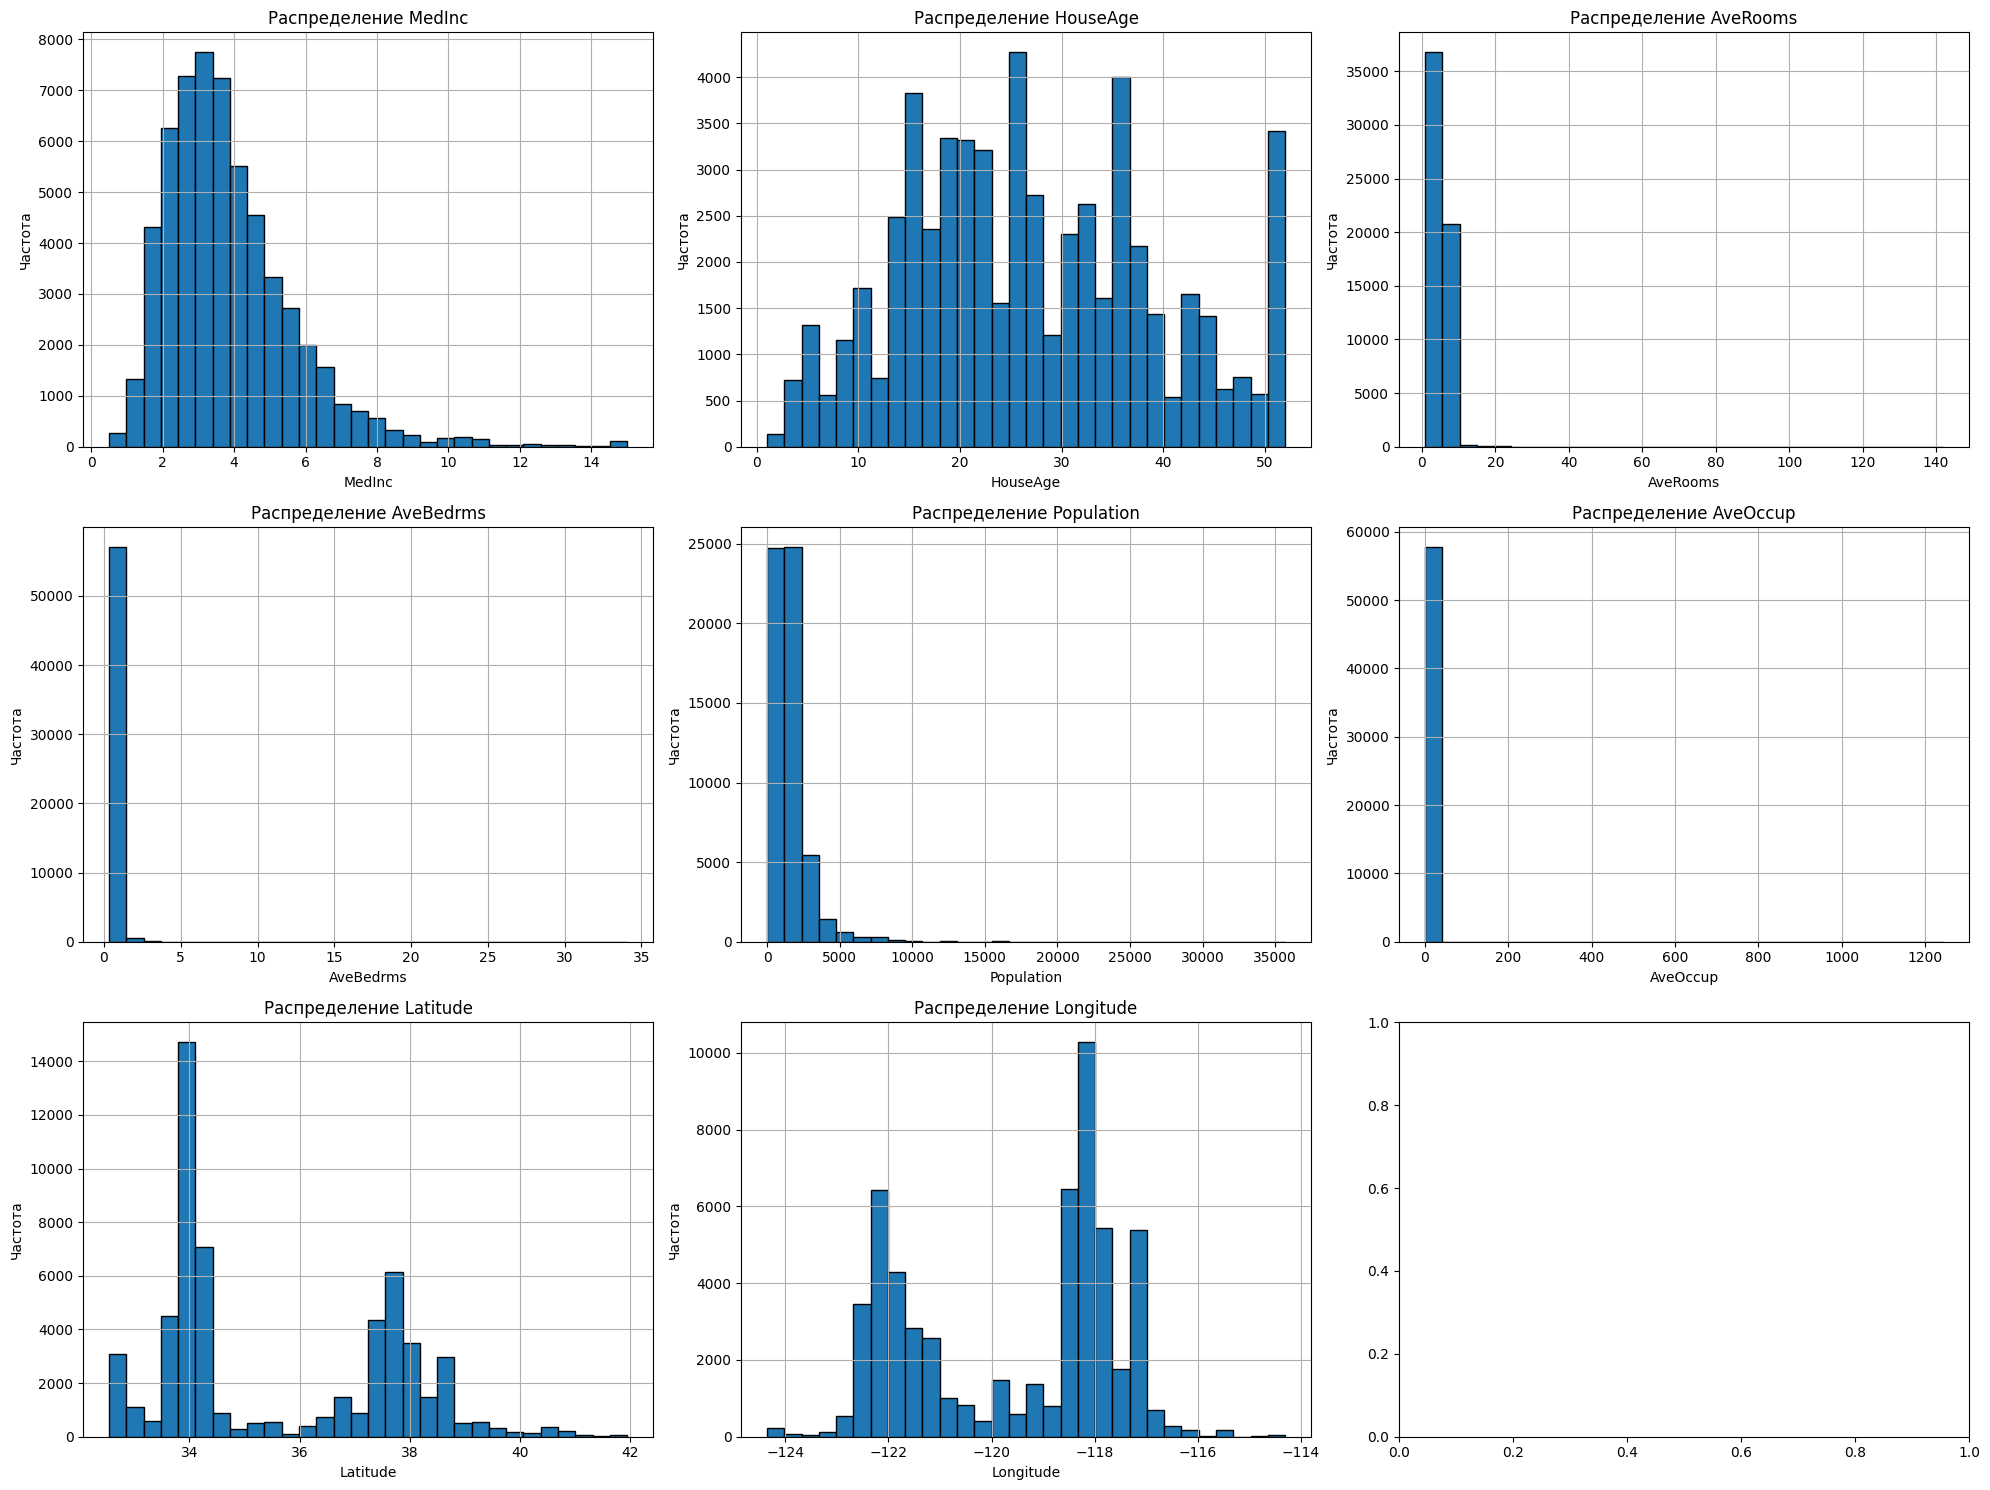

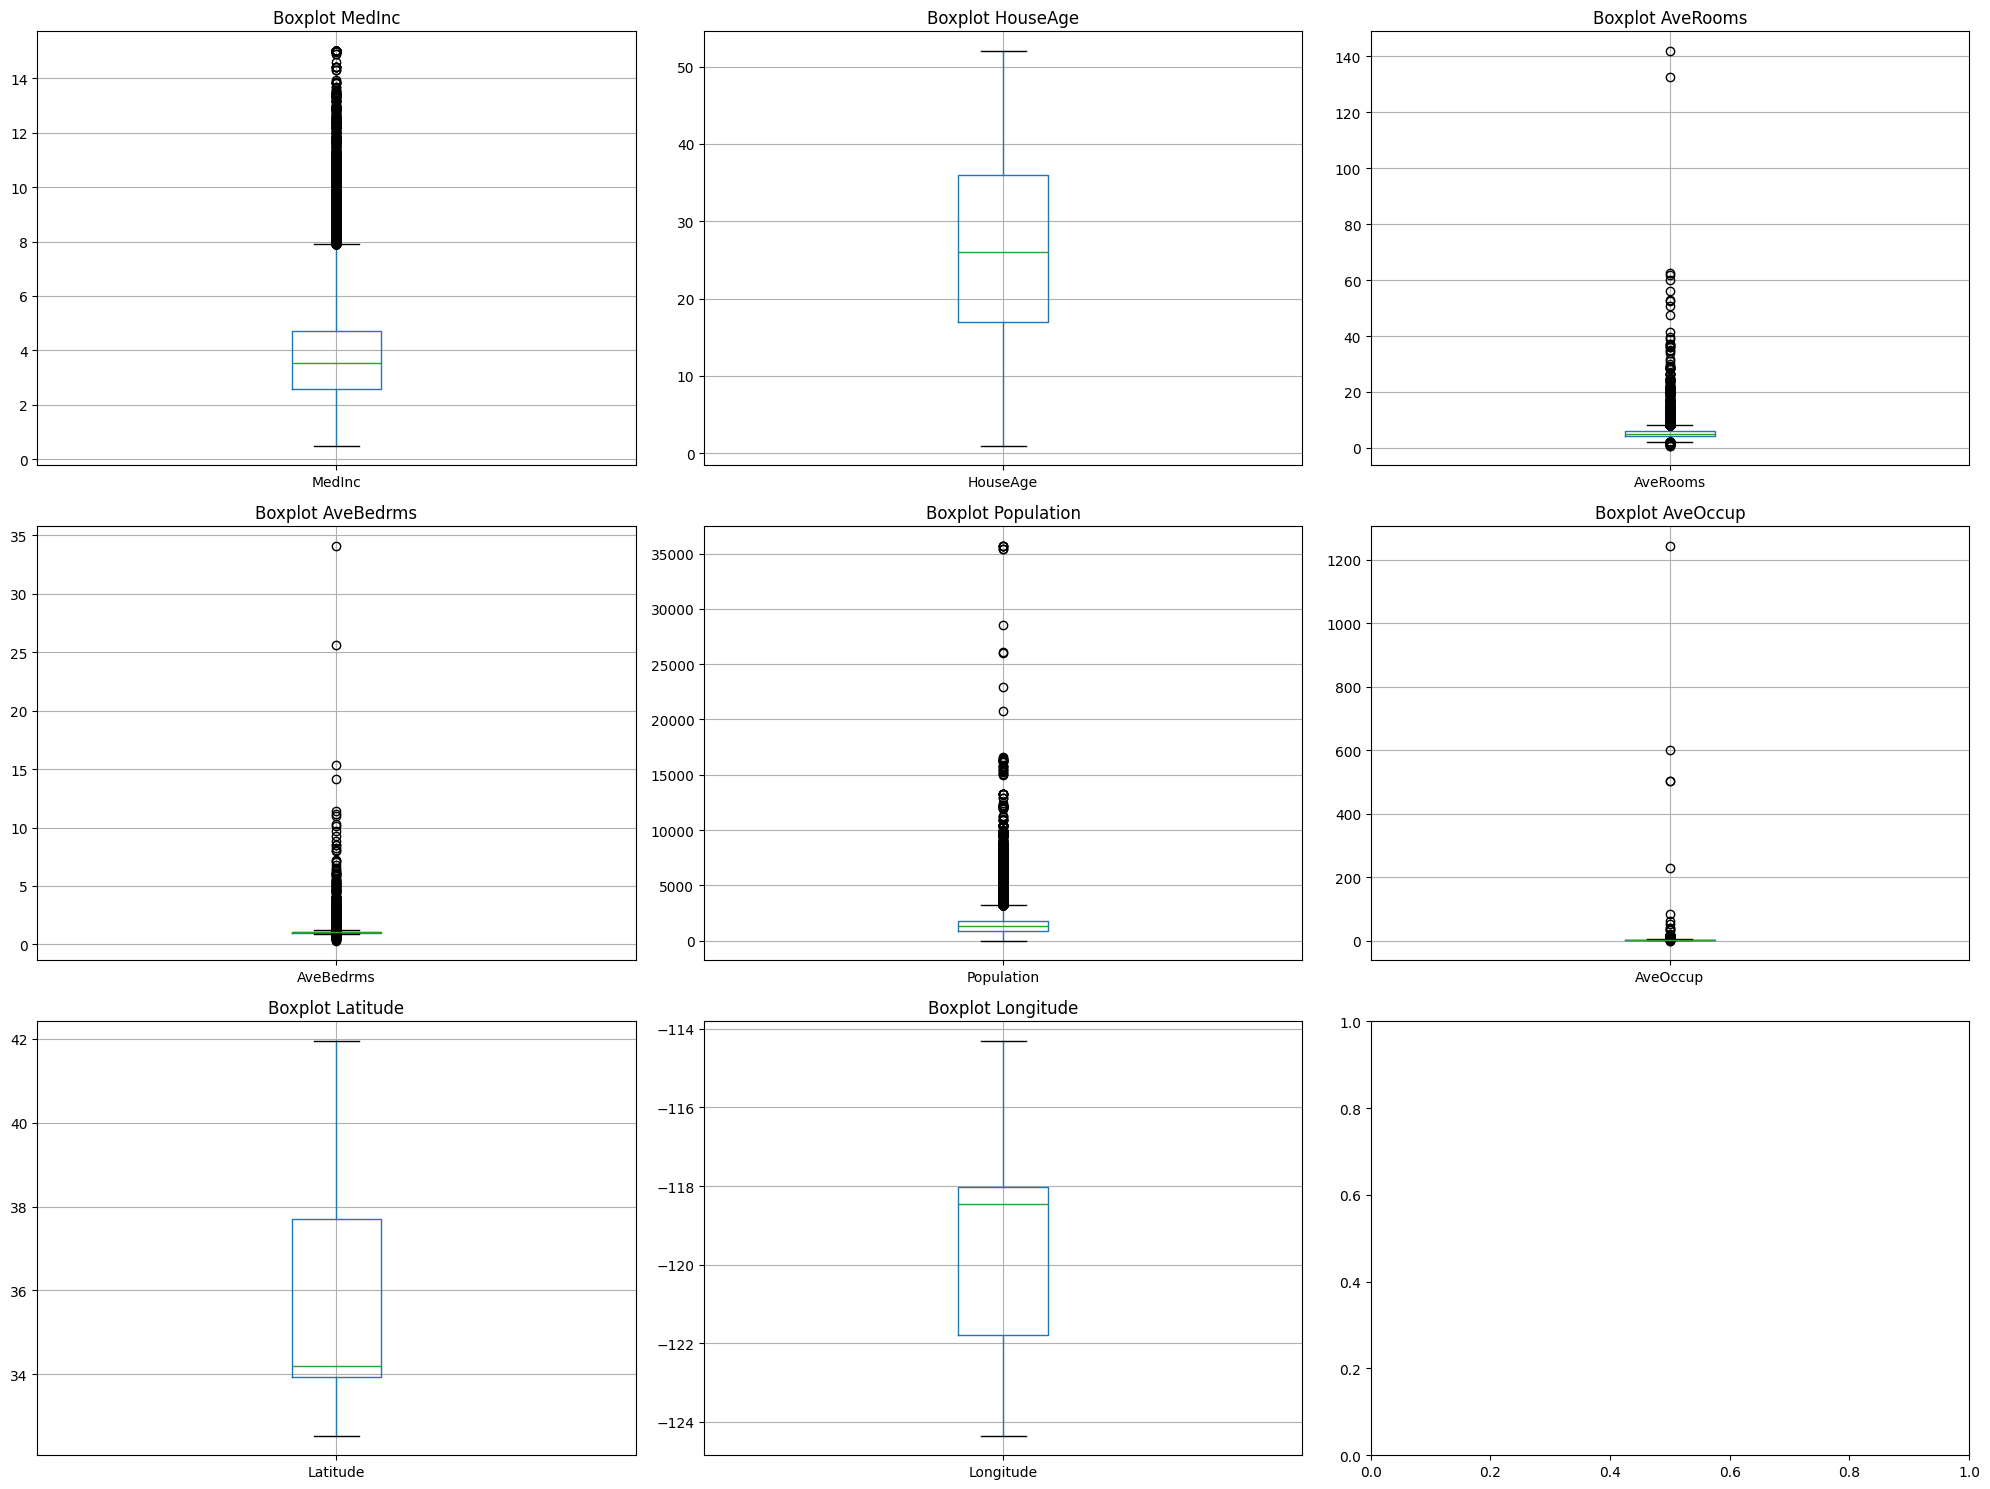

In [13]:
# Визуализация
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:8]):
    train[col].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# Boxplots для анализа выбросов
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:12]):
    train.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

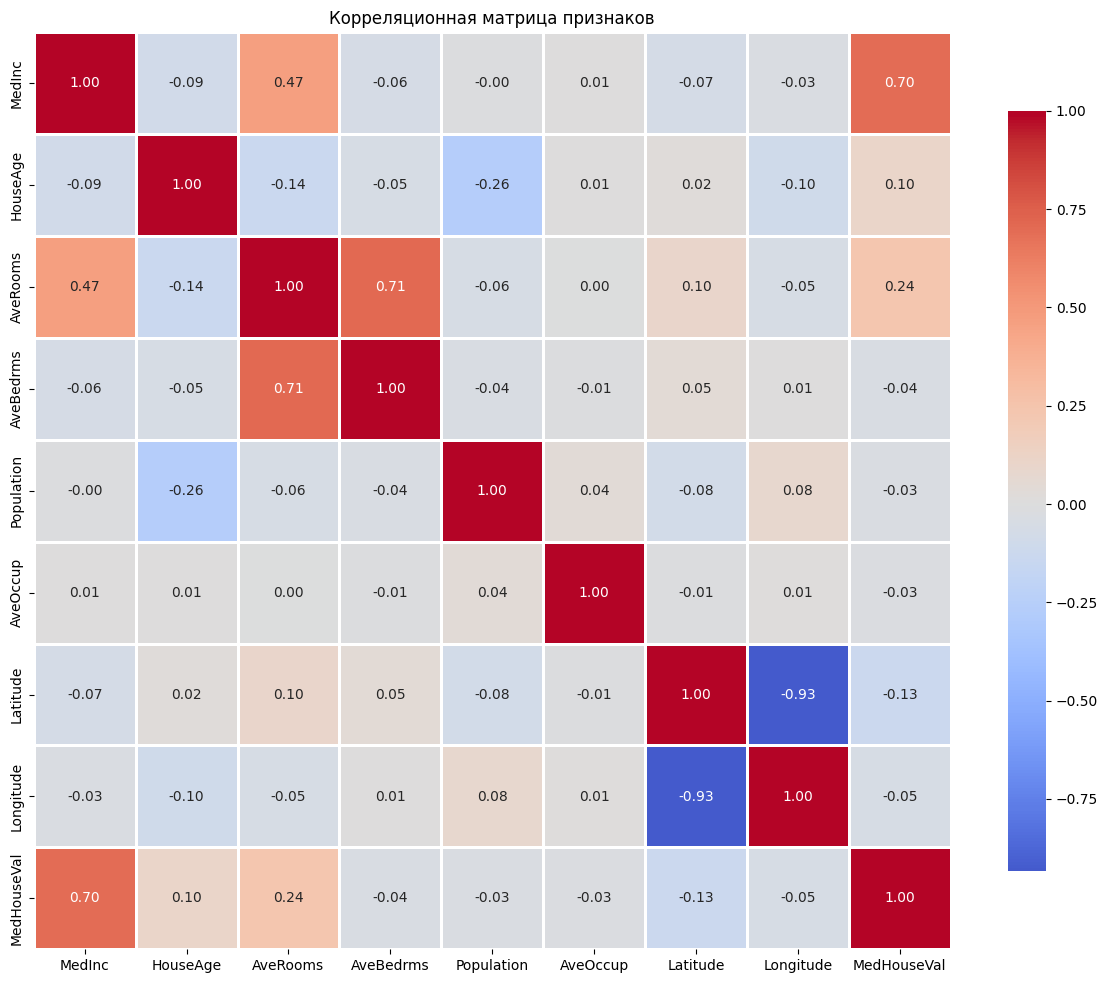


Корреляция с целевой переменной MedHouseVal:
MedHouseVal    1.000000
MedInc         0.696527
AveRooms       0.236013
HouseAge       0.103085
AveOccup      -0.026262
Population    -0.033360
AveBedrms     -0.041327
Longitude     -0.052846
Latitude      -0.126553
Name: MedHouseVal, dtype: float64


In [14]:
# Корреляционная матрица
corr_matrix = train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

# Корреляция с целевой переменной
target_corr = train.corr()['MedHouseVal'].sort_values(ascending=False)
print("\nКорреляция с целевой переменной MedHouseVal:")
print(target_corr)

## Функции для удаления выбросов ##

In [15]:
# Функция для удаления выбросов по квантилям
def remove_outliers_quantiles(X, y, columns, lower_quantile=0.01, upper_quantile=0.99):
    """
    Удаляет выбросы по квантилям для указанных колонок в X,
    применяя фильтр также к y.
    Возвращает очищенные X и y.
    """
    df_combined = X.copy()
    df_combined['target'] = y # Временно объединяем для согласованной фильтрации

    initial_len = len(df_combined)

    for col in columns:
        if col in df_combined.columns:
            lower_bound = df_combined[col].quantile(lower_quantile)
            upper_bound = df_combined[col].quantile(upper_quantile)

            # Удаляем строки за пределами квантилей
            mask = (df_combined[col] >= lower_bound) & (df_combined[col] <= upper_bound)
            df_combined = df_combined[mask]

    removed = initial_len - len(df_combined)
    # print(f"Удалено {removed} строк ({removed/initial_len*100:.2f}%)")

    X_clean = df_combined.drop('target', axis=1)
    y_clean = df_combined['target']

    return X_clean, y_clean

## Тест эффективности удаления выбросов на визуализации распределений ##

In [16]:
# Удаляем выбросы из признаков (кроме целевой переменной и координат, которые обработаем отдельно)
feature_cols = [col for col in numeric_cols if col not in ['MedHouseVal', 'Latitude', 'Longitude']]
X_clean_viz, y_clean_viz = remove_outliers_quantiles(X, y, columns=feature_cols, lower_quantile=0.01, upper_quantile=0.99)

print(f"\nРазмер до очистки: {len(train)}")
print(f"Размер после очистки: {len(X_clean_viz)}")



Размер до очистки: 57777
Размер после очистки: 51984


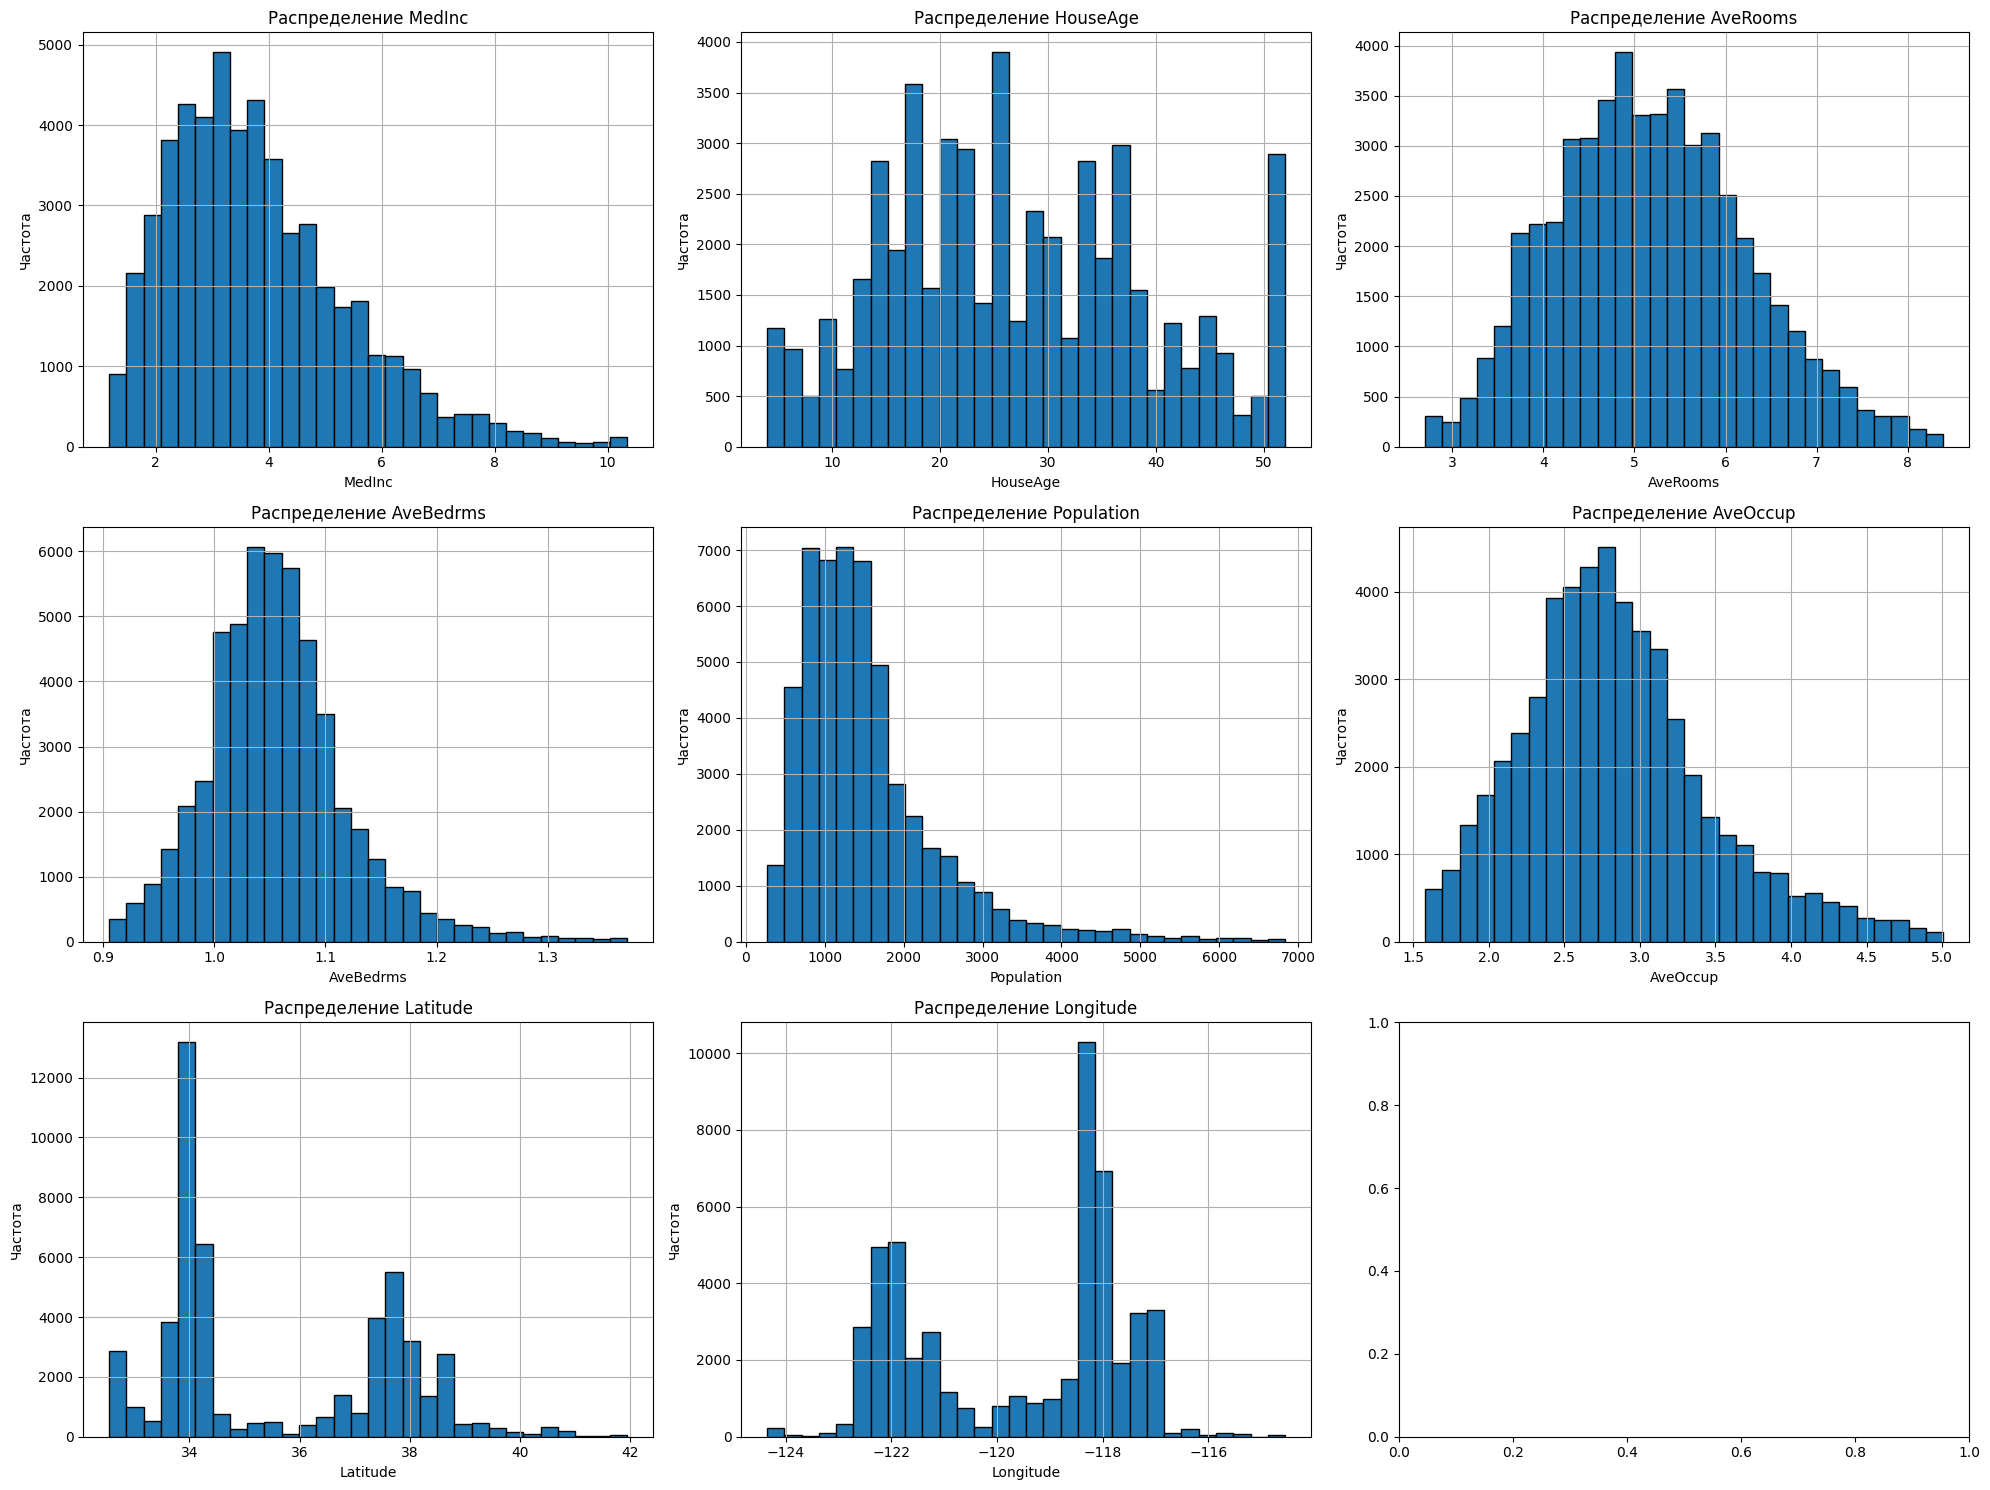

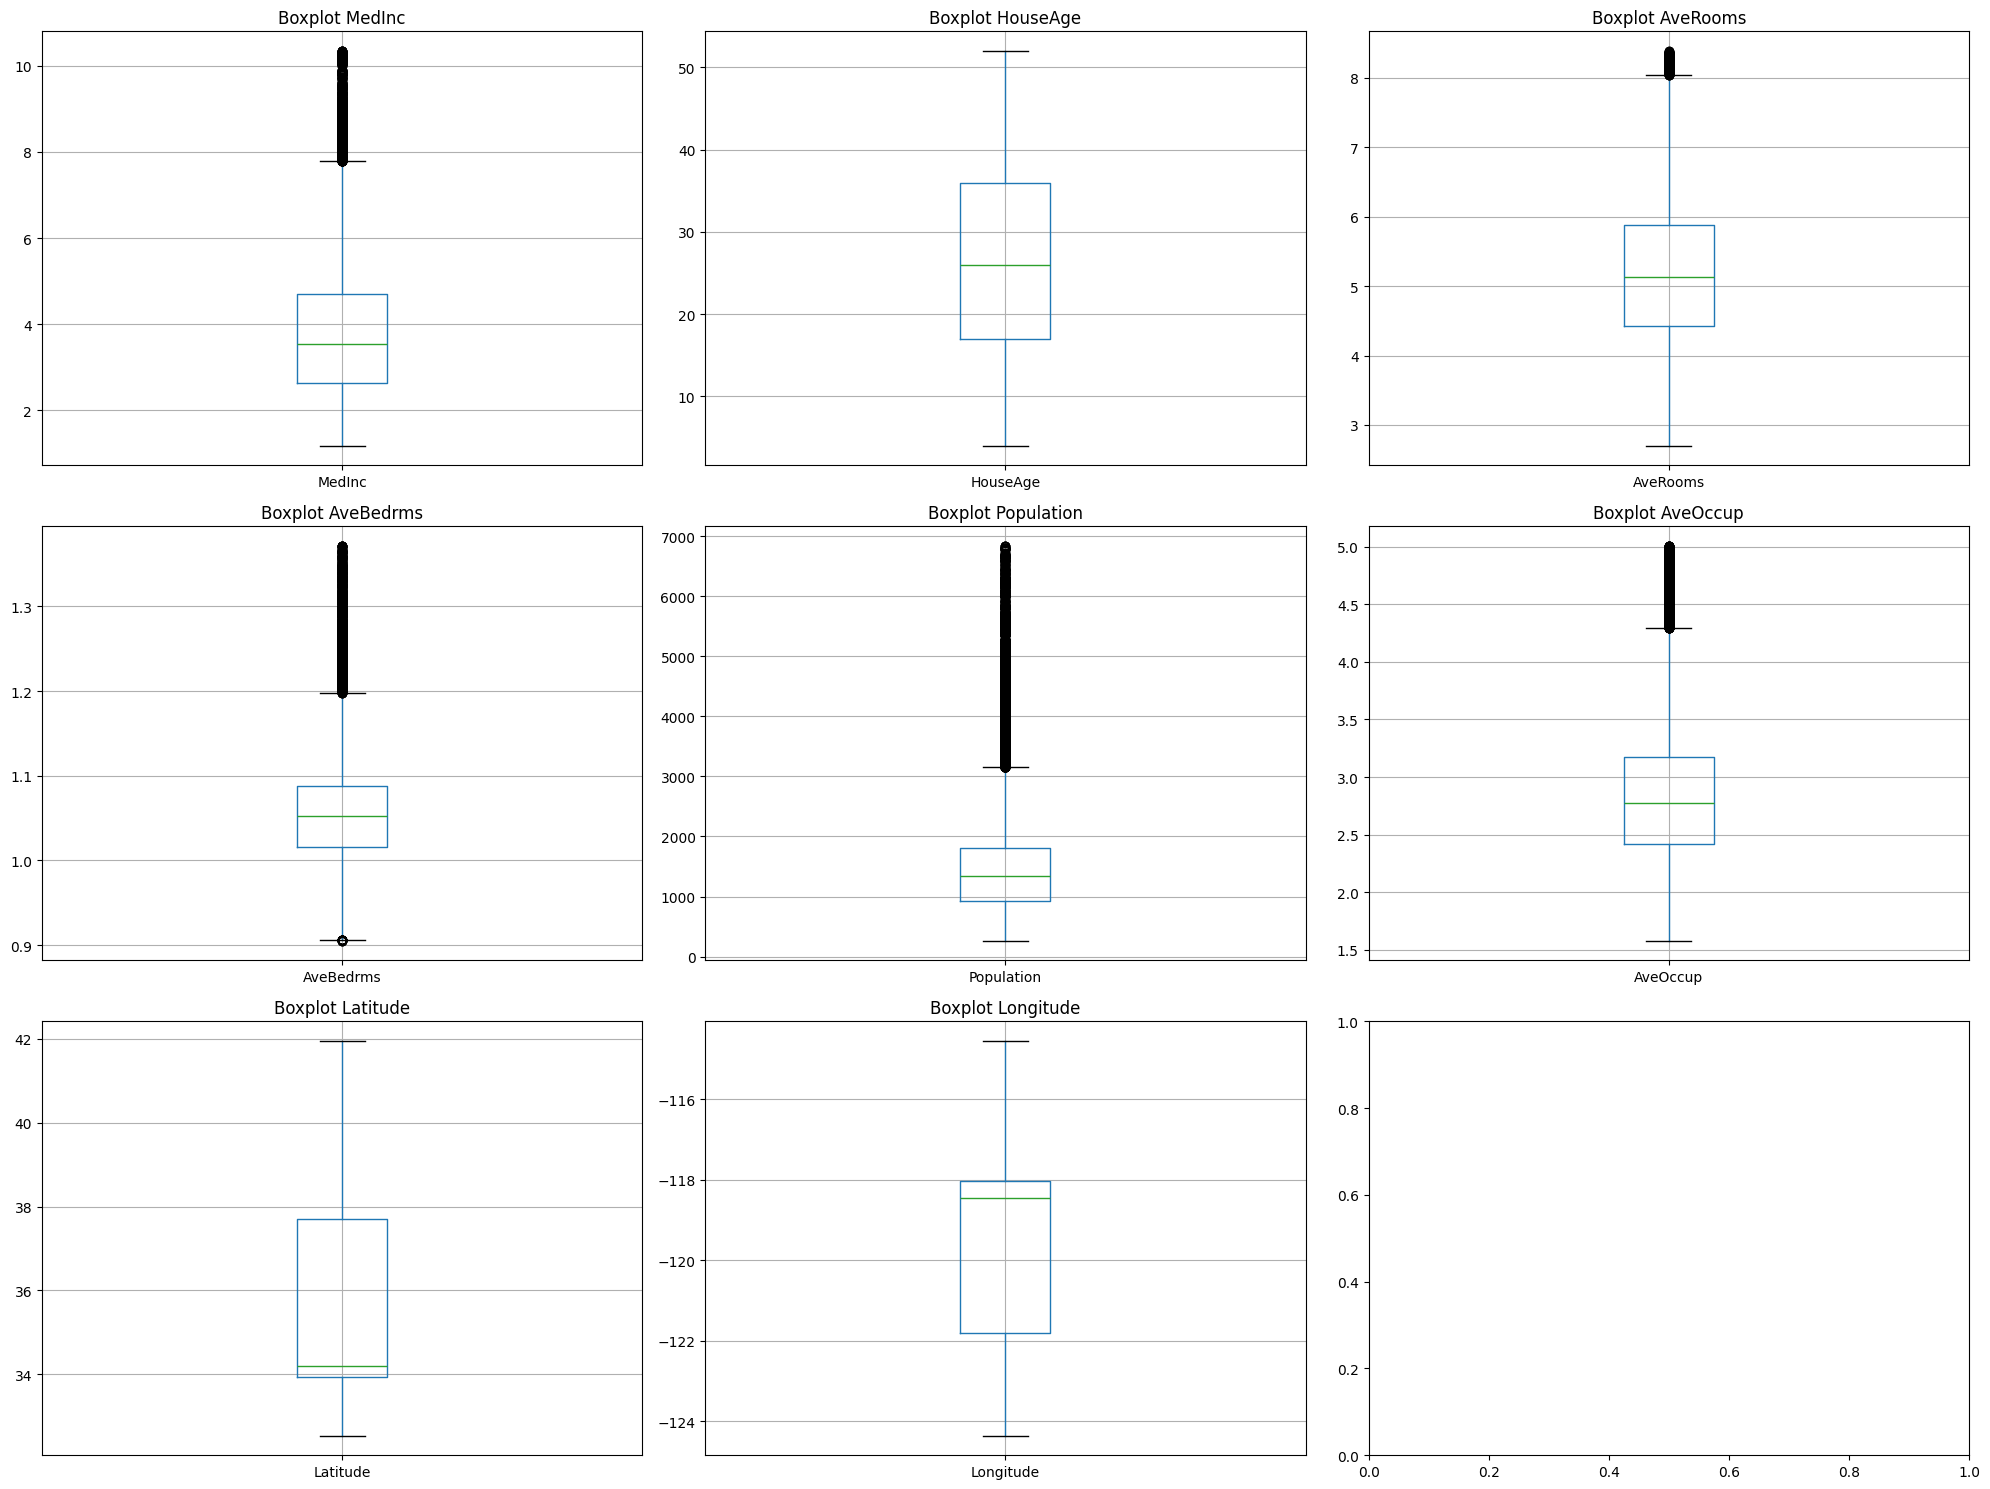

In [17]:
# Визуализация
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:8]):
    X_clean_viz[col].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# Boxplots для анализа выбросов
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:8]):
    X_clean_viz.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

## Обучение бейзлайн модели - базовые фичи + уделение выбросов ##

Учим модель на базовых признаках, с стандартизацией

In [18]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

LGBM_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 3000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'min_child_samples': 20,
    'lambda_l1': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1  # Отключаем вывод логов
}

n_folds = 5

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
scores = []
feature_importances = []
test_predictions_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{n_folds} ---")

    # Разделение
    X_train_fold = X.iloc[train_idx].copy()
    X_val_fold = X.iloc[val_idx].copy()
    y_train_fold = y.iloc[train_idx].copy()
    y_val_fold = y.iloc[val_idx].copy()

    # 1. Обработка выбросов ВНУТРИ фолда
    X_train_fold, y_train_fold = remove_outliers_quantiles(
        X_train_fold, y_train_fold, feature_cols,
        lower_quantile=0.01, upper_quantile=0.99
    )

    # scaler = RobustScaler()
    # X_train_fold_clean = pd.DataFrame(
    #     scaler.fit_transform(X_train_fold_clean),
    #     columns=X_train_fold_clean.columns,
    #     index=X_train_fold_clean.index
    # )
    # X_val_fold = pd.DataFrame(
    #     scaler.transform(X_val_fold),
    #     columns=X_val_fold.columns,
    #     index=X_val_fold.index
    # )

    # 3. Обучение модели
    model = lgb.LGBMRegressor(**LGBM_PARAMS)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    # 4. Предсказание и оценка
    y_pred = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")

    # Сохраняем важность признаков
    feature_importances.append(model.feature_importances_)

print(f"\n{'='*50}")
print(f"Средний RMSE: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
print(f"Min RMSE: {np.min(scores):.4f}, Max RMSE: {np.max(scores):.4f}")


--- Fold 1/5 ---
Fold 1 RMSE: 0.5199

--- Fold 2/5 ---
Fold 2 RMSE: 0.5344

--- Fold 3/5 ---
Fold 3 RMSE: 0.5247

--- Fold 4/5 ---
Fold 4 RMSE: 0.5443

--- Fold 5/5 ---
Fold 5 RMSE: 0.5293

Средний RMSE: 0.5305 (±0.0084)
Min RMSE: 0.5199, Max RMSE: 0.5443


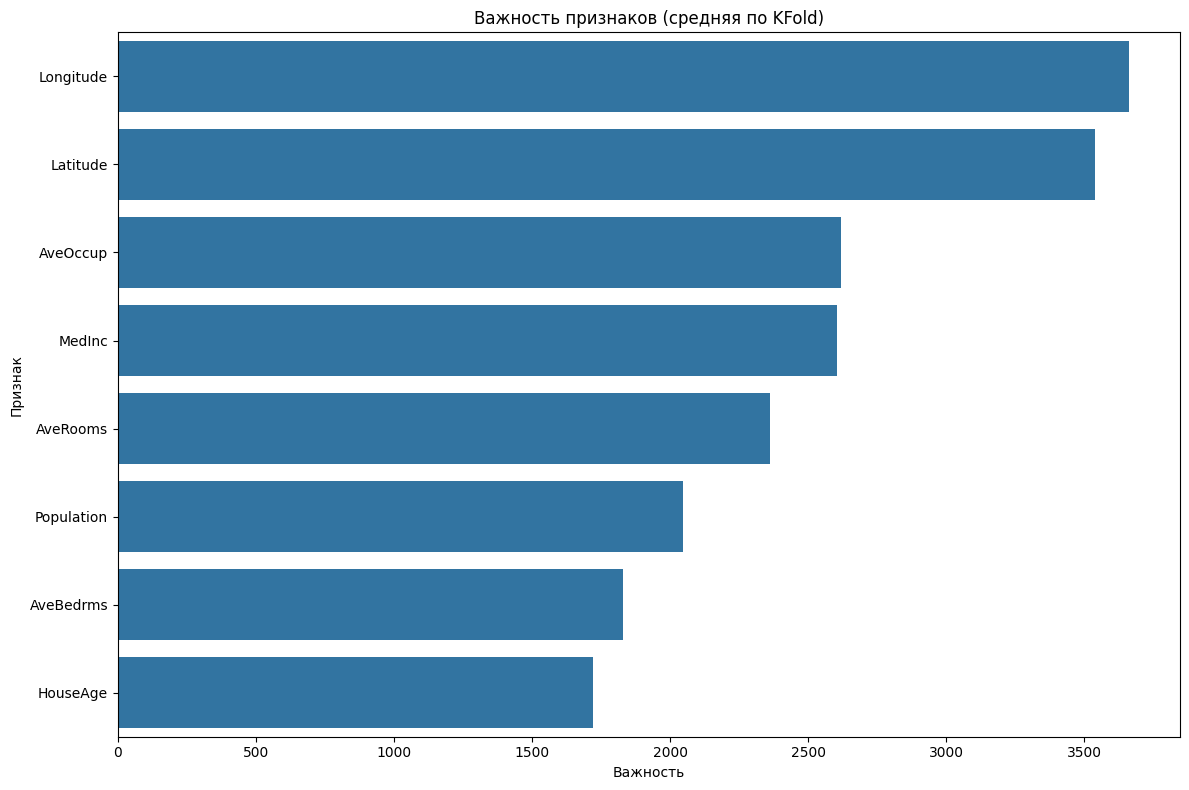

In [19]:
# Агрегируем важность признаков
avg_importances = np.mean(feature_importances, axis=0)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': avg_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Важность признаков (средняя по KFold)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

## Выводы ##

1. Удадение выбросов - ничего не меняет, RMSE становится ниже (0.5638 - без, 0.5677 - с)

2. Scaling почти ничего не меняет.

# -------- Конец базового пайплайна ----- #

Пробуем генерить фичи

In [20]:
 !pip install haversine

In [21]:
from haversine import haversine

# Функция для создания признаков взаимодействия
def create_interaction_features(df):
    df_copy = df.copy()
    df_copy['RoomsPerBedroom'] = df_copy['AveRooms'] / (df_copy['AveBedrms'] + 1e-6)
    df_copy['PeoplePerRoom'] = df_copy['Population'] / (df_copy['AveRooms'] + 1e-6)
    df_copy['IncomePerPerson'] = df_copy['MedInc'] / (df_copy['Population'] + 1e-6)
    df_copy['inc_rooms']      = df_copy['MedInc'] * df_copy['AveRooms']
    df_copy['age_rooms']      = df_copy['HouseAge'] * df_copy['AveRooms']
    df_copy['pop_rooms']      = df_copy['Population'] * df_copy['AveRooms']
    # df_copy['dist_to_coast']  = np.abs(df_copy['Longitude'] + 122.5) # This feature is handled by add_nearest_coast_coords
    df_copy['lat_long']       = df_copy['Latitude'] * df_copy['Longitude']
    df_copy['bedroom_ratio']  = df_copy['AveBedrms'] / (df_copy['AveRooms'] + 1e-6)
    df_copy['rooms_per_occ']  = df_copy['AveRooms'] / (df_copy['AveOccup'] + 1)

    return df_copy

# Функция для создания географических признаков
def create_geographic_features(df, lat_center, lon_center):
    df_copy = df.copy()
    # Расстояние до центра
    SC = (38.576931, -121.494949)
    SF = (37.780080, -122.420160)
    SJ = (37.334789, -121.888138)
    LA = (34.052235, -118.243683)
    SD = (32.715759, -117.163818)

    df_copy['dist_SC'] = df_copy.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SC, unit='ft'), axis=1)
    df_copy['dist_SF'] = df_copy.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SF, unit='ft'), axis=1)
    df_copy['dist_SJ'] = df_copy.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SJ, unit='ft'), axis=1)
    df_copy['dist_LA'] = df_copy.apply(lambda x: haversine((x['Latitude'], x['Longitude']), LA, unit='ft'), axis=1)
    df_copy['dist_SD'] = df_copy.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SD, unit='ft'), axis=1)
    df_copy['dist_nearest_city'] = df_copy[['dist_SC', 'dist_SF', 'dist_SJ',
                                'dist_LA', 'dist_SD']].min(axis=1)
    return df_copy

# Функция для создания полиномиальных признаков
def create_polynomial_features(df):
    df_copy = df.copy()
    df_copy['MedInc_sq'] = df_copy['MedInc'] ** 2
    df_copy['HouseAge_sq'] = df_copy['HouseAge'] ** 2
    return df_copy

# Функция для создания логарифмических признаков
def create_log_features(df):
    df_copy = df.copy()
    df_copy['log_Population'] = np.log1p(df_copy['Population'])
    df_copy['log_AveOccup'] = np.log1p(df_copy['AveOccup'])
    df_copy['log_MedInc'] = np.log1p(df_copy['MedInc'])
    return df_copy

# Функция для создания биннинговых признаков
def create_binned_features(df):
    df_copy = df.copy()
    df_copy['HouseAge_binned'] = pd.cut(df_copy['HouseAge'], bins=5, labels=False, include_lowest=True)
    return df_copy

# Применение функций к train_clean
# train_clean = create_interaction_features(train_clean)
# train_clean = create_geographic_features(train_clean, lat_center, lon_center)
# train_clean = create_polynomial_features(train_clean)
# train_clean = create_log_features(train_clean)
# train_clean = create_binned_features(train_clean)

# print("Feature engineering functions defined and applied to train_clean.")

## Показываем причину генерации фичей с расстоянием до центоров крупных городов ##

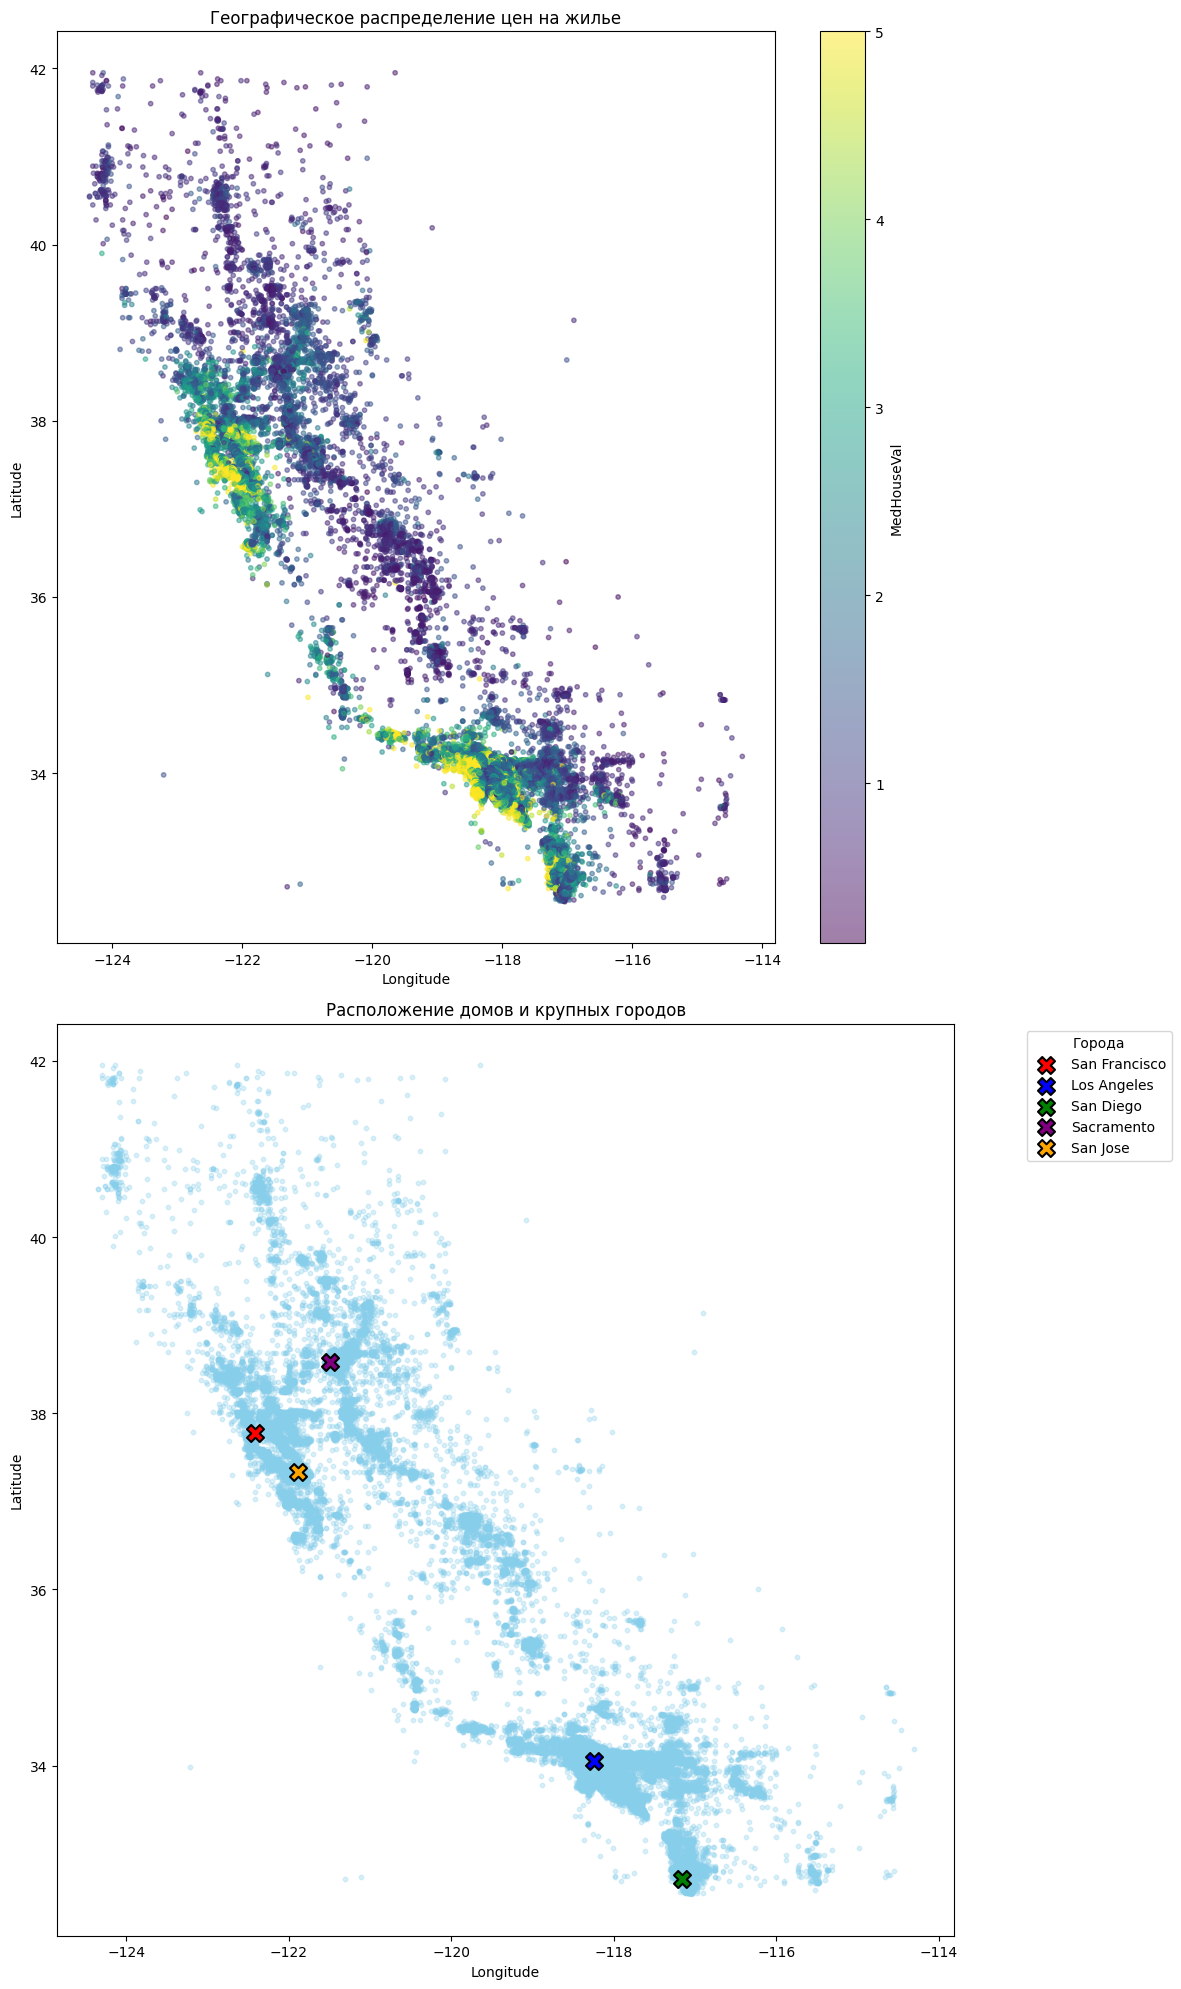

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(12, 20)) # Изменено на 2 строки, 1 столбец

train_viz = train.copy()

# Координаты крупных городов
sf_lat, sf_lon = 37.7749, -122.4194  # San Francisco
la_lat, la_lon = 34.0522, -118.2437  # Los Angeles
sd_lat, sd_lon = 32.7157, -117.1611  # San Diego
sc_lat, sc_lon = 38.5769, -121.4949  # Sacramento
sj_lat, sj_lon = 37.3347, -121.8881  # San Jose

# --- Первая карта (верхняя): Распределение цен ---
scatter1 = axes[0].scatter(train_viz['Longitude'], train_viz['Latitude'],
                     c=train_viz['MedHouseVal'], cmap='viridis',
                     alpha=0.5, s=10)
fig.colorbar(scatter1, ax=axes[0], label='MedHouseVal')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Географическое распределение цен на жилье')

# --- Вторая карта (нижняя): Расположение городов ---
axes[1].scatter(train_viz['Longitude'], train_viz['Latitude'],
                  color='skyblue', alpha=0.3, s=10) # Все точки одного цвета

# Добавляем метки городов на вторую карту
axes[1].scatter(sf_lon, sf_lat, color='red', marker='X', s=150, label='San Francisco', edgecolor='black', linewidth=1.5)
axes[1].scatter(la_lon, la_lat, color='blue', marker='X', s=150, label='Los Angeles', edgecolor='black', linewidth=1.5)
axes[1].scatter(sd_lon, sd_lat, color='green', marker='X', s=150, label='San Diego', edgecolor='black', linewidth=1.5)
axes[1].scatter(sc_lon, sc_lat, color='purple', marker='X', s=150, label='Sacramento', edgecolor='black', linewidth=1.5)
axes[1].scatter(sj_lon, sj_lat, color='orange', marker='X', s=150, label='San Jose', edgecolor='black', linewidth=1.5)

axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Расположение домов и крупных городов')
axes[1].legend(title='Города', loc='upper right', bbox_to_anchor=(1.25, 1)) # Корректировка положения легенды

plt.tight_layout()
plt.show()

### Смотрим, имеет ли смысл использования расстояния до центра всех координат из train ###

Центр координат (train): Latitude=35.5921, Longitude=-119.5598


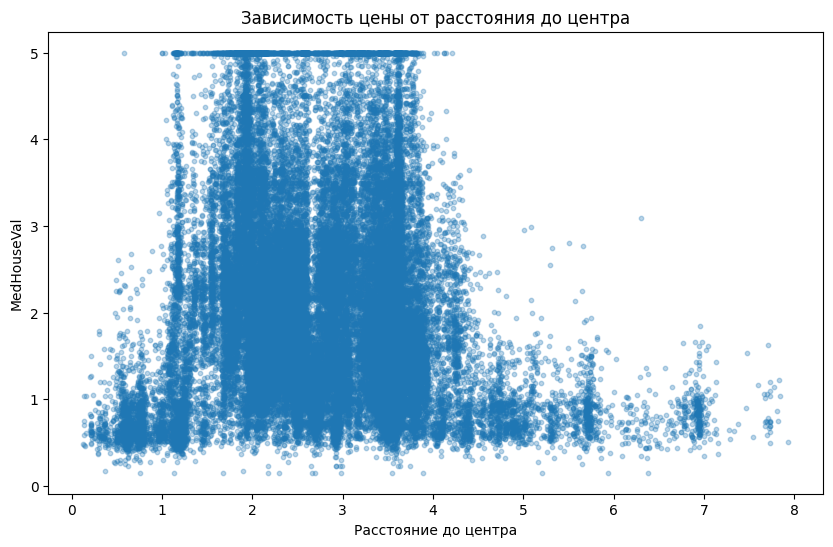


Корреляция DistanceToCenter с MedHouseVal: -0.085


In [23]:
# Найдем центр на train данных
lat_center = train_viz['Latitude'].mean()
lon_center = train_viz['Longitude'].mean()
print(f"Центр координат (train): Latitude={lat_center:.4f}, Longitude={lon_center:.4f}")

# Вычислим расстояние до центра (евклидово расстояние)
train_viz['DistanceToCenter'] = np.sqrt((train_viz['Latitude'] - lat_center)**2 +
                                    (train_viz['Longitude'] - lon_center)**2)

# Визуализация расстояния до центра
plt.figure(figsize=(10, 6))
plt.scatter(train_viz['DistanceToCenter'], train_viz['MedHouseVal'], alpha=0.3, s=10)
plt.xlabel('Расстояние до центра')
plt.ylabel('MedHouseVal')
plt.title('Зависимость цены от расстояния до центра')
plt.show()

print(f"\nКорреляция DistanceToCenter с MedHouseVal: {train_viz['DistanceToCenter'].corr(train_viz['MedHouseVal']):.3f}")

## Кластеризация ##

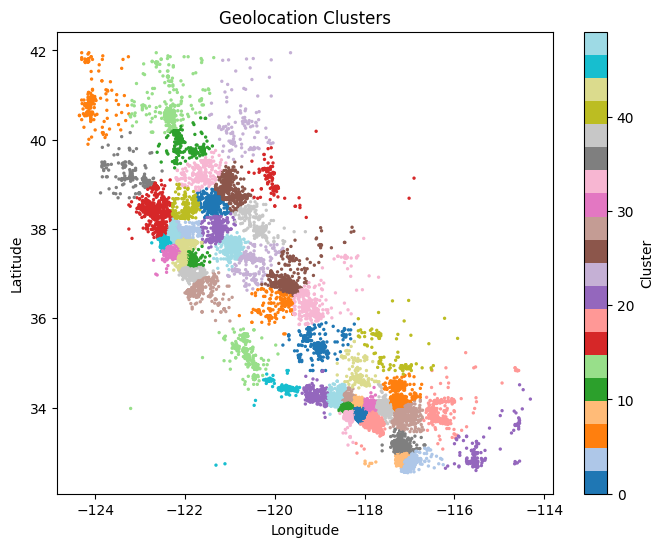

In [24]:
from sklearn.cluster import MiniBatchKMeans

train_viz = train.copy()

coords = train_viz[['Latitude','Longitude']]
mbk = MiniBatchKMeans(n_clusters=50, batch_size=1000, random_state=42)
train_viz['loc_cluster'] = mbk.fit_predict(coords)

plt.figure(figsize=(8,6))
plt.scatter(train_viz['Longitude'], train_viz['Latitude'], c=train_viz['loc_cluster'], cmap='tab20', s=2)
plt.title("Geolocation Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Cluster')
plt.show()

In [25]:
def add_clusters(df: pd.DataFrame, df_test=None):
    df_copy = df.copy()

    coords = df_copy[['Latitude','Longitude']]
    mbk = MiniBatchKMeans(n_clusters=50, batch_size=1000, random_state=42)
    df_copy['loc_cluster'] = mbk.fit_predict(coords)

    if df_test is not None:
        df_test['loc_cluster'] = mbk.predict(df_test[['Latitude','Longitude']])

    return df_copy, df_test

#### Вывод - корреляция незначительная, явного прироста цены нет, значит стоит использовать расстояние до городов ####

## Теперь будем географически объяснять другие пики цен. В основном, они приходятся на прибрежные территории, посмотрим расположения пляжей

In [26]:
from shapely.geometry import LineString, Point

def add_nearest_coast_coords(df: pd.DataFrame):
    copy_df = df.copy()

    coast_points = LineString([(32.664, -117.161), (33.206, -117.383),
                           (33.777, -118.202), (34.463, -120.014),
                           (35.427, -120.881), (35.928, -121.489),
                           (36.982, -122.028), (37.611, -122.491),
                           (38.355, -123.060), (39.792, -123.821),
                           (40.799, -124.188), (41.755, -124.197)])

    # Используем apply с Point и distance для расчета расстояния до LineString
    # Note: df.apply(lambda x: Point(x['Latitude'], x['Longitude']), axis=1) создает серию объектов Point
    # А затем вызываем метод distance для каждого объекта Point с LineString
    copy_df['dist_to_coast'] = copy_df.apply(lambda x: Point(x['Latitude'], x['Longitude']).distance(coast_points), axis=1)
    copy_df['is_coastal'] = (copy_df['dist_to_coast'] < 0.1).astype(int)

    return copy_df

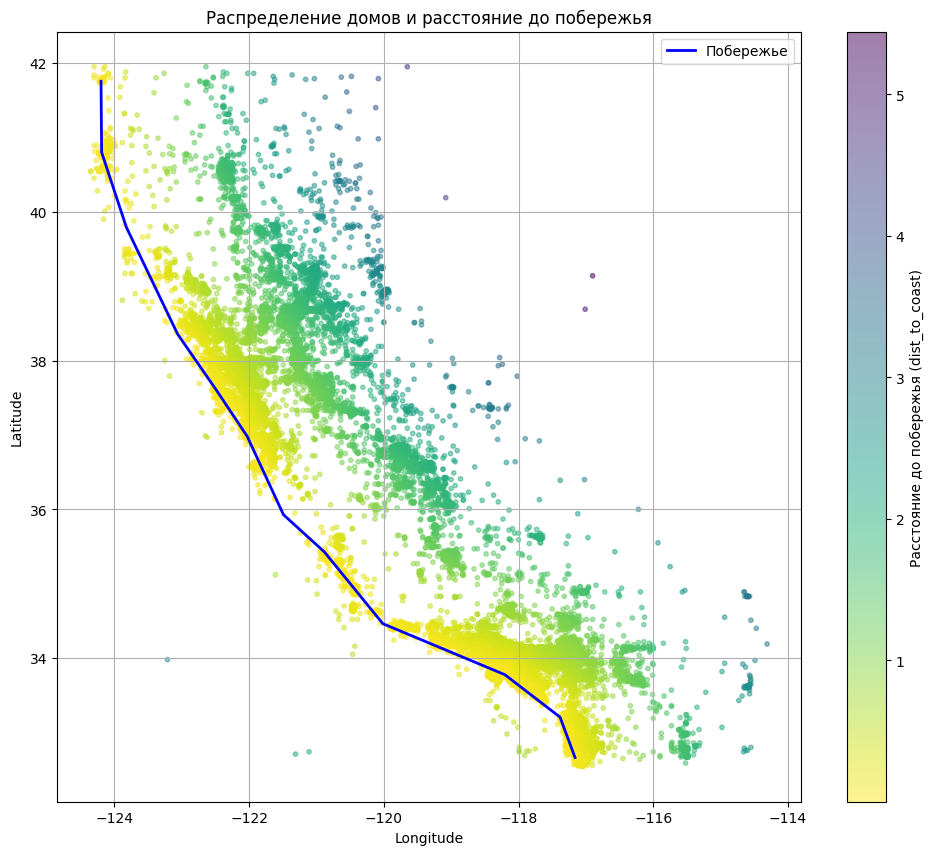

In [27]:
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
import seaborn as sns

# Применяем функцию для расчета dist_to_coast к данным train
train_with_coast = add_nearest_coast_coords(train.copy())

# Определяем точки побережья для визуализации
coast_points_coords = [
    (32.664, -117.161), (33.206, -117.383),
    (33.777, -118.202), (34.463, -120.014),
    (35.427, -120.881), (35.928, -121.489),
    (36.982, -122.028), (37.611, -122.491),
    (38.355, -123.060), (39.792, -123.821),
    (40.799, -124.188), (41.755, -124.197)
]
coast_lon = [p[1] for p in coast_points_coords]
coast_lat = [p[0] for p in coast_points_coords]

plt.figure(figsize=(12, 10))

# Визуализация распределения dist_to_coast
scatter = plt.scatter(train_with_coast['Longitude'], train_with_coast['Latitude'],
                      c=train_with_coast['dist_to_coast'], cmap='viridis_r', # _r для инверсии цвета (меньше расстояние = темнее)
                      alpha=0.5, s=10)
plt.colorbar(scatter, label='Расстояние до побережья (dist_to_coast)')

# Добавляем линию побережья
plt.plot(coast_lon, coast_lat, color='blue', linewidth=2, label='Побережье')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Распределение домов и расстояние до побережья')
plt.legend()
plt.grid(True)
plt.show()

## Повороты координат ##

In [28]:
def add_rotations(df: pd.DataFrame):
    copy_df = df.copy()

    copy_df['rot_15_x'] = (np.cos(np.radians(15)) * copy_df['Longitude']) + \
                    (np.sin(np.radians(15)) * copy_df['Latitude'])

    copy_df['rot_15_y'] = (np.cos(np.radians(15)) * copy_df['Latitude']) + \
                    (np.sin(np.radians(15)) * copy_df['Longitude'])

    copy_df['rot_30_x'] = (np.cos(np.radians(30)) * copy_df['Longitude']) + \
                    (np.sin(np.radians(30)) * copy_df['Latitude'])

    copy_df['rot_30_y'] = (np.cos(np.radians(30)) * copy_df['Latitude']) + \
                    (np.sin(np.radians(30)) * copy_df['Longitude'])

    copy_df['rot_45_x'] = (np.cos(np.radians(45)) * copy_df['Longitude']) + \
                    (np.sin(np.radians(45)) * copy_df['Latitude'])

    copy_df['rot_45_y'] = (np.cos(np.radians(45)) * copy_df['Latitude']) + \
                    (np.sin(np.radians(45)) * copy_df['Longitude'])

    return copy_df

### Визульаное обоснование эффективности - большая разделимость данных - см. визуализации ###

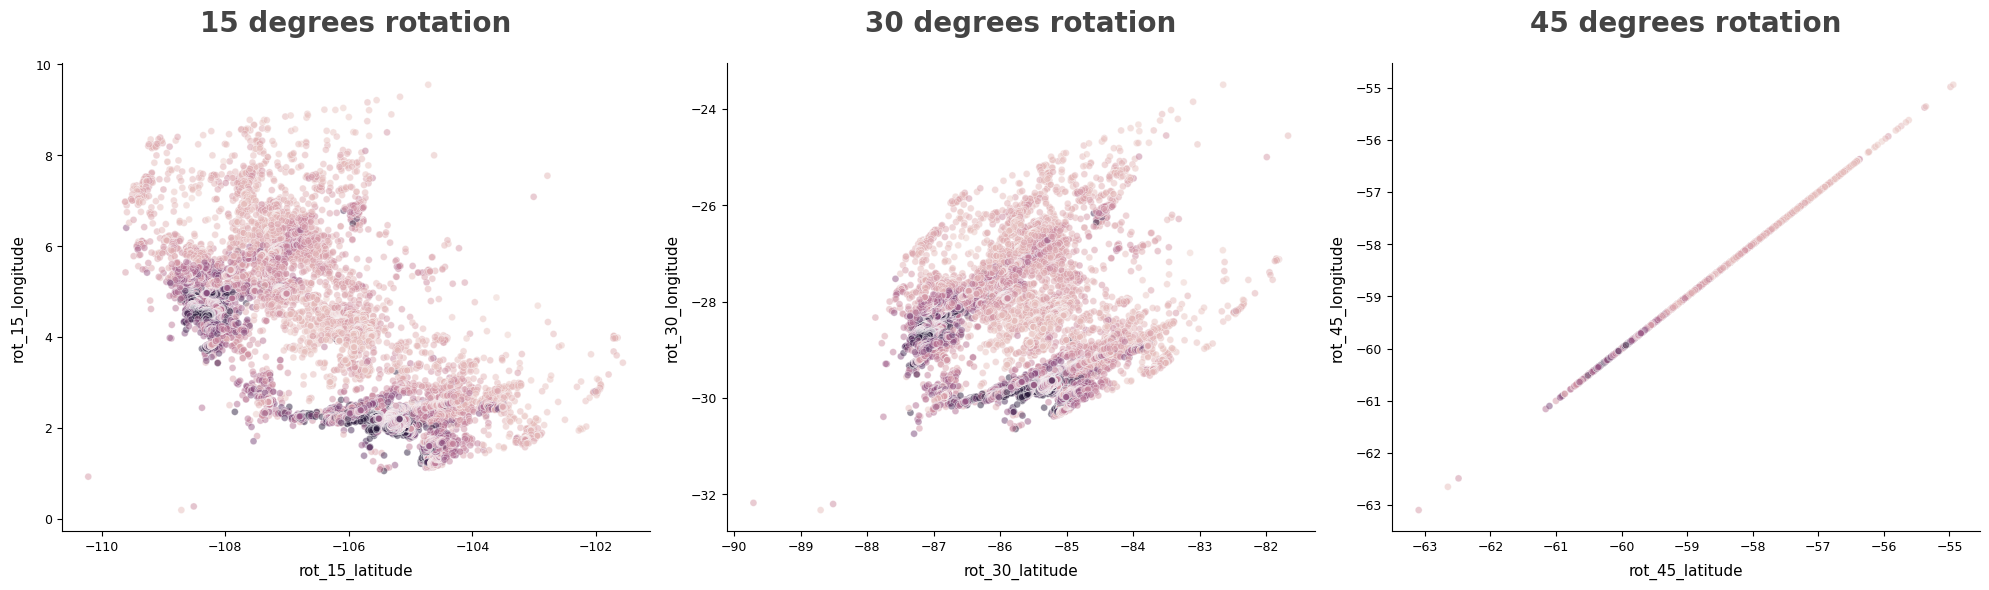

In [29]:
train_viz = add_rotations(train)

fig = plt.figure(figsize=(20, 6)) # Увеличиваем размер для 3х графиков

for i, col_angle in enumerate(['15', '30', '45']): # Добавляем '45' в список углов
    plt.subplot(1, 3, i + 1) # Изменяем количество столбцов на 3
    plt.title(f'{col_angle} degrees rotation', size=20, y=1.05, fontname='Calibri',
              fontweight='bold', color='#444444')
    # Удаляем palette=sns.color_palette('YlOrBr', as_cmap=True)
    a = sns.scatterplot(data=train_viz, x=f'rot_{col_angle}_x', y=f'rot_{col_angle}_y', hue='MedHouseVal',
                        s=25, alpha=0.5)
    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xlabel(f'rot_{col_angle}_latitude', labelpad=7, fontsize=11)
    plt.ylabel(f'rot_{col_angle}_longitude', labelpad=7, fontsize=11)

    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
    a.get_legend().remove()

plt.tight_layout()
plt.show()

## Еще разнообразные идеи для фич ##

In [30]:
def add_pca_coords(df):
    coordinates = df[["Latitude", "Longitude"]]

    pca_obj = PCA().fit(coordinates.values)

    df_copy = df.copy()

    df_copy["pca_lat"] = pca_obj.transform(coordinates)[:, 0]
    df_copy["pca_lon"] = pca_obj.transform(coordinates)[:, 1]

    return df_copy

def add_polar_coords(df):
    df_copy = df.copy()

    df_copy["r"] = np.sqrt(df_copy["Latitude"] ** 2 + df_copy["Longitude"] ** 2)
    df_copy["theta"] = np.arctan2(df_copy["Latitude"], df_copy["Longitude"])

    return df_copy

# Отбор фич #

1. Составляем датасет со всеми идеями фич

In [31]:
X_fe = X.copy()
y_fe = y.copy()

X_test_fe = test.drop(['id'], axis=1, errors='ignore').copy()

In [32]:
def apply_features(df: pd.DataFrame):
    lat_center, lon_center = 37.0, -119.5

    df_copy = df.copy()

    df_copy = create_interaction_features(df_copy)
    df_copy = create_geographic_features(df_copy, lat_center, lon_center)
    df_copy = create_log_features(df_copy)
    df_copy = add_nearest_coast_coords(df_copy)
    df_copy = add_rotations(df_copy)
    df_copy = add_pca_coords(df_copy)
    df_copy = add_polar_coords(df_copy)
    df_copy, _ = add_clusters(df_copy)

    return df_copy

In [33]:
X_fe = apply_features(X_fe)
X_fe.columns.to_list()

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'RoomsPerBedroom',
 'PeoplePerRoom',
 'IncomePerPerson',
 'inc_rooms',
 'age_rooms',
 'pop_rooms',
 'lat_long',
 'bedroom_ratio',
 'rooms_per_occ',
 'dist_SC',
 'dist_SF',
 'dist_SJ',
 'dist_LA',
 'dist_SD',
 'dist_nearest_city',
 'log_Population',
 'log_AveOccup',
 'log_MedInc',
 'dist_to_coast',
 'is_coastal',
 'rot_15_x',
 'rot_15_y',
 'rot_30_x',
 'rot_30_y',
 'rot_45_x',
 'rot_45_y',
 'pca_lat',
 'pca_lon',
 'r',
 'theta',
 'loc_cluster']

Посмотрим на корреляцию между новыми фичами


Найдено 44 пар фич с корреляцией > 0.95:
  MedInc <-> log_MedInc: 0.9652
  Latitude <-> lat_long: -0.9968
  Latitude <-> dist_SC: -0.9579
  Latitude <-> dist_SD: 0.9924
  Latitude <-> rot_15_y: 0.9929
  Latitude <-> pca_lat: 0.9850
  Latitude <-> r: 0.9613
  Latitude <-> theta: -0.9909
  Longitude <-> lat_long: 0.9583
  Longitude <-> dist_SF: 0.9657
  ... и еще 34 пар


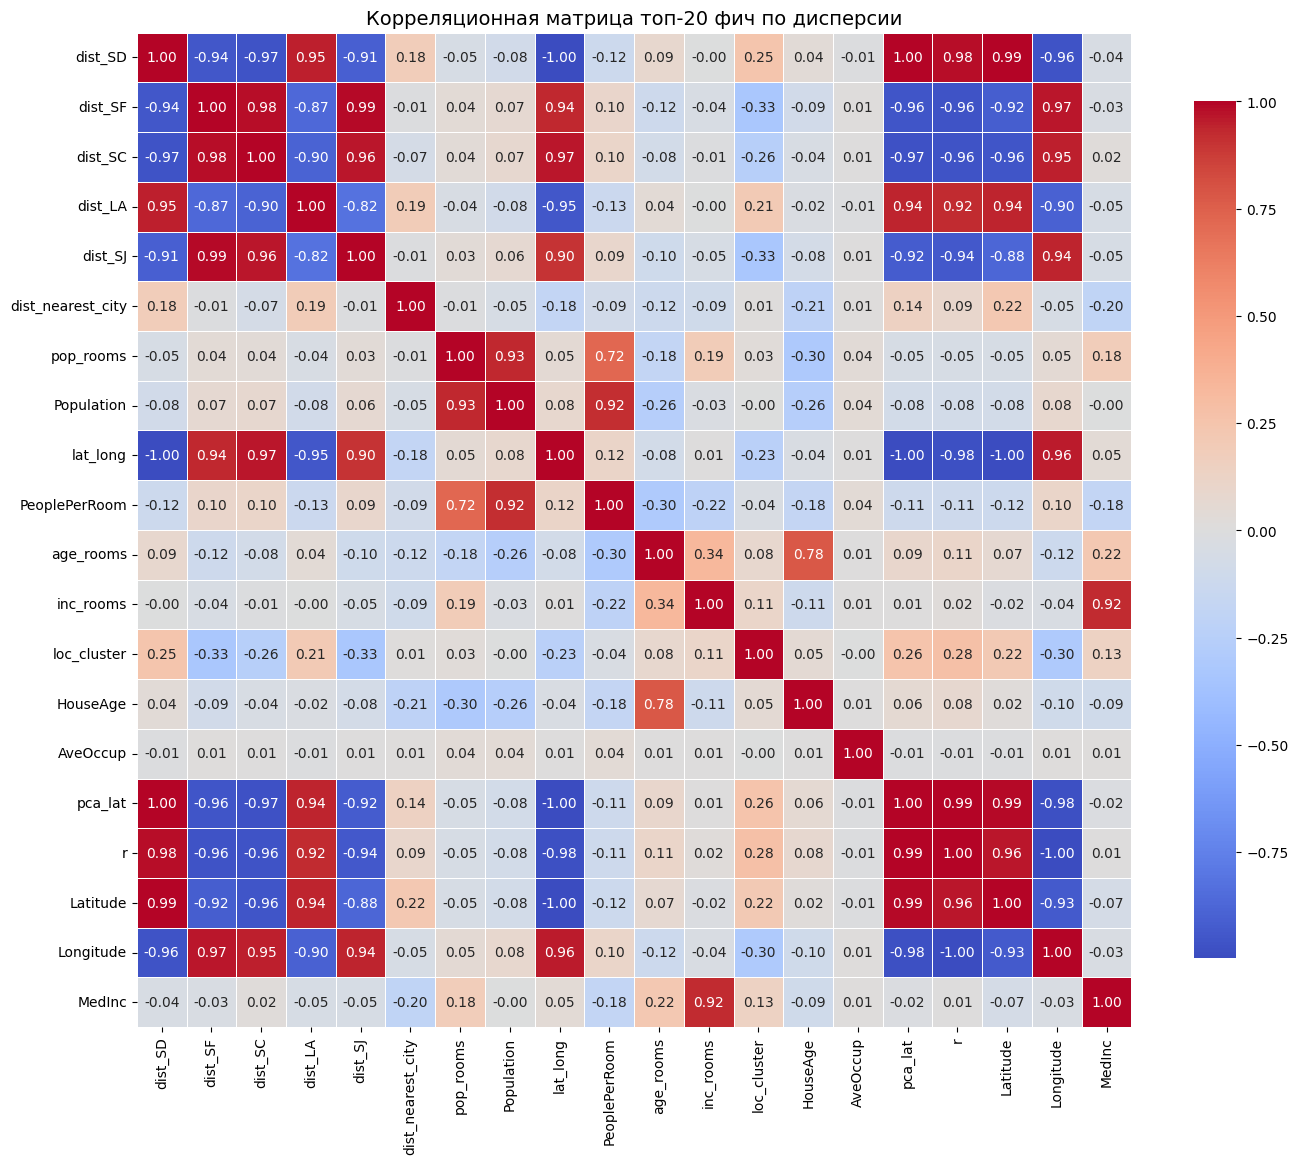


Топ-15 фич по абсолютной корреляции с целевой переменной:
   1. MedHouseVal                   : 1.0000
   2. MedInc                        : 0.6965
   3. log_MedInc                    : 0.6822
   4. inc_rooms                     : 0.6021
   5. rot_45_y                      : 0.4888
   6. rot_45_x                      : 0.4888
   7. pca_lon                       : 0.4884
   8. dist_to_coast                 : 0.4719
   9. RoomsPerBedroom               : 0.3907
  10. dist_nearest_city             : 0.3593
  11. rooms_per_occ                 : 0.2990
  12. rot_30_y                      : 0.2934
  13. bedroom_ratio                 : 0.2747
  14. rot_30_x                      : 0.2697
  15. age_rooms                     : 0.2477


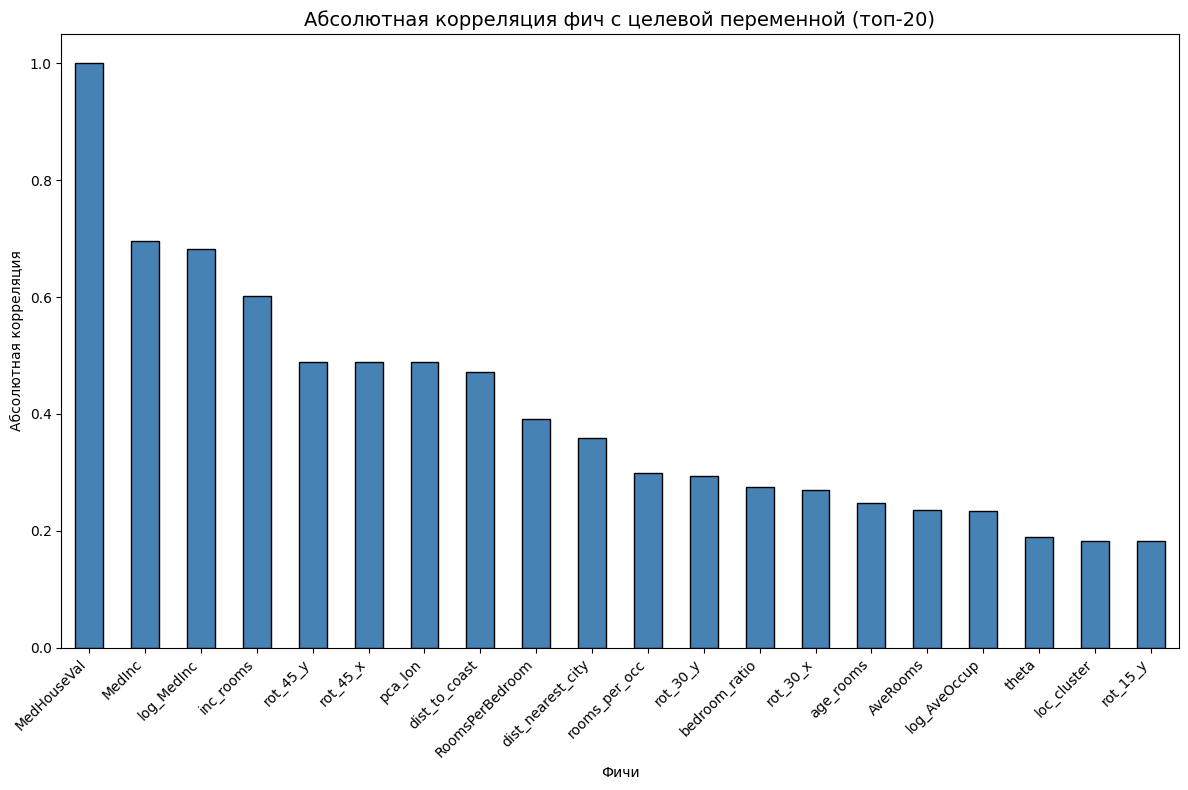

In [34]:
corr_matrix = X_fe.corr()

# Находим высококоррелированные пары фич
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f"\nНайдено {len(high_corr_pairs)} пар фич с корреляцией > 0.95:")
for feature1, feature2, corr_value in high_corr_pairs[:10]:  # Показываем первые 10
    print(f"  {feature1} <-> {feature2}: {corr_value:.4f}")

if len(high_corr_pairs) > 10:
    print(f"  ... и еще {len(high_corr_pairs) - 10} пар")

# Визуализируем матрицу корреляций для топ-20 фич по дисперсии
# Выбираем фичи с наибольшей дисперсией
feature_variances = X_fe.var().sort_values(ascending=False)
top_features = feature_variances.head(20).index.tolist()

plt.figure(figsize=(14, 12))
sns.heatmap(X_fe[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица топ-20 фич по дисперсии', fontsize=14)
plt.tight_layout()
plt.show()

# Анализируем корреляции с целевой переменной
X_all_with_target = X_fe.copy()
X_all_with_target['MedHouseVal'] = y_fe

target_correlations = X_all_with_target.corr()['MedHouseVal'].abs().sort_values(ascending=False)

print("\nТоп-15 фич по абсолютной корреляции с целевой переменной:")
for i, (feature, corr) in enumerate(target_correlations.head(15).items()):
    print(f"  {i+1:2d}. {feature:30s}: {corr:.4f}")

# Визуализация
plt.figure(figsize=(12, 8))
target_correlations.head(20).plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Абсолютная корреляция фич с целевой переменной (топ-20)', fontsize=14)
plt.xlabel('Фичи')
plt.ylabel('Абсолютная корреляция')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Учим модель на всех фичах ##

In [35]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
import gc

LGBM_PARAMS_KF = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'min_child_samples': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

# Настройки KFold
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Контейнеры для результатов
fold_scores = []
feature_importances_folds = []
feature_names = X_fe.columns.tolist()

print(f"Запускаем {n_folds}-fold кросс-валидацию...")
print(f"Количество фич для оценки: {len(feature_names)}")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_fe, y_fe)):
    print(f"\n--- Fold {fold+1}/{n_folds} ---")

    # Разделение данных
    X_train_fold = X_fe.iloc[train_idx].copy()
    X_val_fold = X_fe.iloc[val_idx].copy()
    y_train_fold = y_fe.iloc[train_idx].copy()
    y_val_fold = y_fe.iloc[val_idx].copy()

    # Создаем и обучаем модель
    model = LGBMRegressor(**LGBM_PARAMS_KF)

    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    # Оценка модели
    y_pred = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    fold_scores.append(rmse)
    print(f"RMSE fold {fold+1}: {rmse:.4f}")

    # Сохраняем важность фич
    importance_dict = dict(zip(feature_names, model.feature_importances_))
    feature_importances_folds.append(importance_dict)

    # Очистка памяти
    del X_train_fold, X_val_fold, y_train_fold, y_val_fold, model
    gc.collect()

print(f"Средний RMSE: {np.mean(fold_scores):.4f} (±{np.std(fold_scores):.4f})")
print(f"Min RMSE: {np.min(fold_scores):.4f}")
print(f"Max RMSE: {np.max(fold_scores):.4f}")
print(f"Количество фич: {len(feature_names)}")

Запускаем 5-fold кросс-валидацию...
Количество фич для оценки: 39

--- Fold 1/5 ---
RMSE fold 1: 0.5059

--- Fold 2/5 ---
RMSE fold 2: 0.5247

--- Fold 3/5 ---
RMSE fold 3: 0.5145

--- Fold 4/5 ---
RMSE fold 4: 0.5361

--- Fold 5/5 ---
RMSE fold 5: 0.5191
Средний RMSE: 0.5200 (±0.0101)
Min RMSE: 0.5059
Max RMSE: 0.5361
Количество фич: 39


## Создаем submission после обучения всех фич ##

In [36]:
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import pandas as pd
import gc

# Helper functions to correctly handle fitting and transforming for PCA and MiniBatchKMeans
# PCA - fits on training data and transforms new data using the fitted object
def _add_pca_coords_fit(df_train):
    coordinates_train = df_train[["Latitude", "Longitude"]]
    pca_obj = PCA().fit(coordinates_train.values)
    return pca_obj

def _add_pca_coords_transform(df, pca_obj):
    df_copy = df.copy()
    coordinates = df_copy[["Latitude", "Longitude"]]
    df_copy["pca_lat"] = pca_obj.transform(coordinates)[:, 0]
    df_copy["pca_lon"] = pca_obj.transform(coordinates)[:, 1]
    return df_copy

# MiniBatchKMeans - fits on training data and transforms new data using the fitted object
def _add_clusters_fit(df_train):
    coords_train = df_train[['Latitude','Longitude']]
    mbk_model = MiniBatchKMeans(n_clusters=50, batch_size=1000, random_state=42, n_init='auto')
    mbk_model.fit(coords_train)
    return mbk_model

def _add_clusters_transform(df, mbk_model):
    df_copy = df.copy()
    coords = df_copy[['Latitude','Longitude']]
    df_copy['loc_cluster'] = mbk_model.predict(coords)
    return df_copy


# Unified feature engineering pipeline function that accepts pre-fitted transformers
def apply_features_for_submission(df: pd.DataFrame, pca_transformer=None, mbk_clusterer=None):
    lat_center, lon_center = 37.0, -119.5
    df_copy = df.copy()

    # Apply interaction, geographic, log, coast, and rotation features (pure transformations)
    df_copy = create_interaction_features(df_copy)
    df_copy = create_geographic_features(df_copy, lat_center, lon_center)
    df_copy = create_log_features(df_copy)
    df_copy = add_nearest_coast_coords(df_copy)
    df_copy = add_rotations(df_copy)

    # Apply PCA transform using the provided transformer
    if pca_transformer:
        df_copy = _add_pca_coords_transform(df_copy, pca_transformer)
    else:
        raise ValueError("PCA transformer must be provided for consistent feature engineering.")

    df_copy = add_polar_coords(df_copy) # This is a pure transformation function

    # Apply MiniBatchKMeans transform using the provided clusterer
    if mbk_clusterer:
        df_copy = _add_clusters_transform(df_copy, mbk_clusterer)
    else:
        raise ValueError("MiniBatchKMeans clusterer must be provided for consistent feature engineering.")

    return df_copy

# --- Main submission generation logic ---

# 1. Prepare raw test data and extract original 'id'
test_ids = test['id'].copy() # 'test' DataFrame is available from the notebook state
X_test_raw_for_fe = test.drop(['id'], axis=1, errors='ignore').copy()

# 2. Fit PCA and MiniBatchKMeans transformers on the full training data (X)
# 'X' DataFrame is available from the notebook state
pca_transformer_fitted = _add_pca_coords_fit(X)
mbk_clusterer_fitted = _add_clusters_fit(X)

# 3. Apply feature engineering to the full training data (X) using the fitted transformers
# This generates the X_fe_processed that will be used for final model training
X_fe_processed = apply_features_for_submission(X.copy(), pca_transformer_fitted, mbk_clusterer_fitted)

# 4. Apply feature engineering to the test data using the *same fitted transformers*
X_test_processed = apply_features_for_submission(X_test_raw_for_fe, pca_transformer_fitted, mbk_clusterer_fitted)

# Ensure columns match between processed train and test data
train_cols_final = X_fe_processed.columns
# If any column is missing in test but present in train, add it with 0 (or appropriate default)
missing_in_test = set(train_cols_final) - set(X_test_processed.columns)
for col in missing_in_test:
    X_test_processed[col] = 0
# Ensure the order of columns is the same
X_test_processed = X_test_processed[train_cols_final]

# 5. Train a final LightGBM model on the entire processed training data
# LGBM_PARAMS_KF and y_fe are available from the notebook state
final_model = lgb.LGBMRegressor(**LGBM_PARAMS_KF)
final_model.fit(X_fe_processed, y_fe) # y_fe is the target variable from the notebook state

# 6. Make predictions on the processed test data
final_test_predictions = final_model.predict(X_test_processed)

# 7. Create the submission DataFrame
submission_df = pd.DataFrame({'id': test_ids, 'MedHouseVal': final_test_predictions})

# 8. Save to CSV
submission_df.to_csv('submission_all_fe.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
print("First 5 rows of the submission file:")
print(submission_df.head())

Submission file 'submission.csv' created successfully.
First 5 rows of the submission file:
      id  MedHouseVal
0  37137     0.703334
1  37138     1.021783
2  37139     3.899836
3  37140     3.169224
4  37141     2.389553


## Анализ важности полученных фич ##

In [37]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Топ-25 самых важных фич по средней важности:
--------------------------------------------------------------------------------
 1. AveOccup                       | Mean:  1387.60 | Std: 302.93 | CV: 0.218
 2. MedInc                         | Mean:  1290.20 | Std: 286.96 | CV: 0.222
 3. rooms_per_occ                  | Mean:   964.60 | Std: 250.00 | CV: 0.259
 4. AveBedrms                      | Mean:   961.20 | Std: 274.21 | CV: 0.285
 5. dist_to_coast                  | Mean:   925.40 | Std: 189.25 | CV: 0.205
 6. dist_nearest_city              | Mean:   864.20 | Std: 193.35 | CV: 0.224
 7. age_rooms                      | Mean:   860.40 | Std: 259.30 | CV: 0.301
 8. IncomePerPerson                | Mean:   767.20 | Std: 213.88 | CV: 0.279
 9. inc_rooms                      | Mean:   728.80 | Std: 247.57 | CV: 0.340
10. AveRooms                       | Mean:   704.00 | Std: 203.98 | CV: 0.290
11. HouseAge                       | Mean:   699.60 | Std: 159.95 | CV: 0.229
12. pop_rooms   

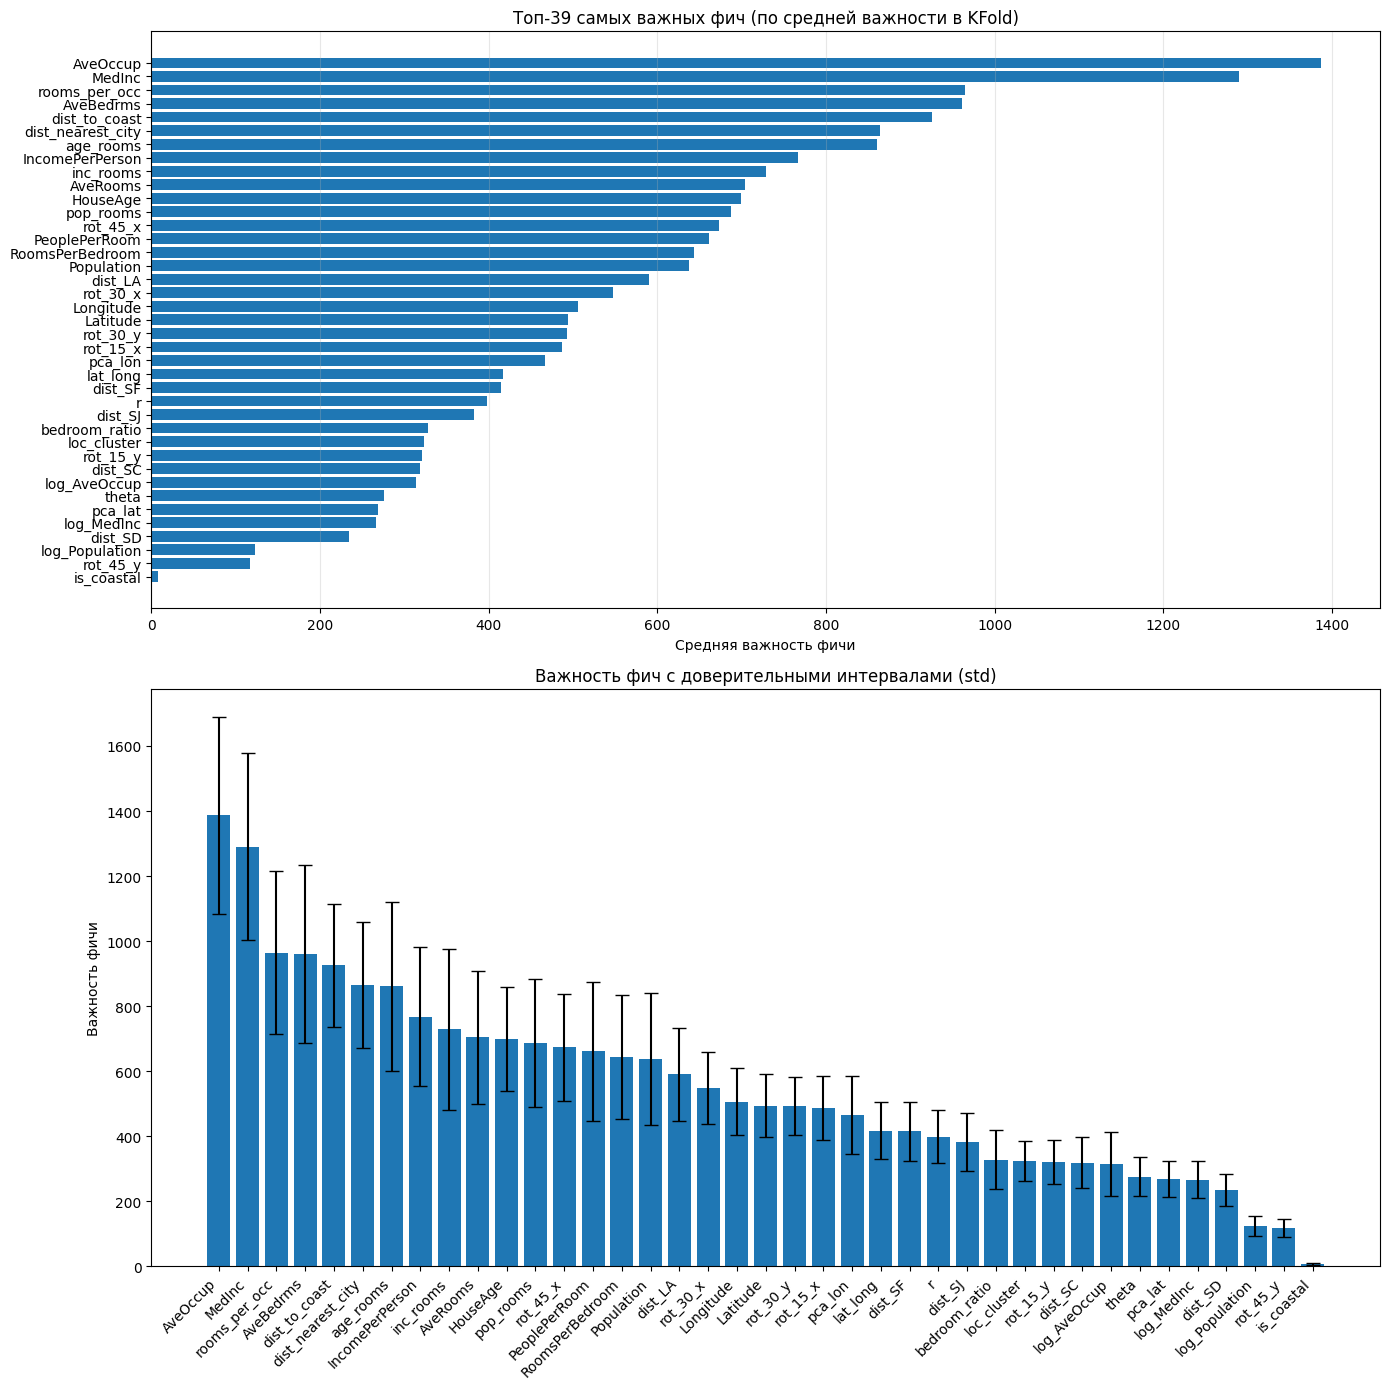


АНАЛИЗ СТАБИЛЬНОСТИ ФИЧ:

Стабильно важные фичи (CV < 0.5): 39
Топ-10 стабильно важных фич:
   1. AveOccup                       | Mean: 1387.60 | CV: 0.218
   2. MedInc                         | Mean: 1290.20 | CV: 0.222
   3. rooms_per_occ                  | Mean: 964.60 | CV: 0.259
   4. AveBedrms                      | Mean: 961.20 | CV: 0.285
   5. dist_to_coast                  | Mean: 925.40 | CV: 0.205
   6. dist_nearest_city              | Mean: 864.20 | CV: 0.224
   7. age_rooms                      | Mean: 860.40 | CV: 0.301
   8. IncomePerPerson                | Mean: 767.20 | CV: 0.279
   9. inc_rooms                      | Mean: 728.80 | CV: 0.340
  10. AveRooms                       | Mean: 704.00 | CV: 0.290
  11. HouseAge                       | Mean: 699.60 | CV: 0.229
  12. pop_rooms                      | Mean: 687.00 | CV: 0.286
  13. rot_45_x                       | Mean: 673.60 | CV: 0.244
  14. PeoplePerRoom                  | Mean: 661.40 | CV: 0.324
  15. Roo

In [38]:
# Создаем DataFrame с важностью фич по всем фолдам
importance_df_folds = pd.DataFrame(feature_importances_folds)

# Рассчитываем статистики по фичам
importance_stats = pd.DataFrame({
    'feature': feature_names,
    'mean_importance': importance_df_folds.mean(),
    'std_importance': importance_df_folds.std(),
    'median_importance': importance_df_folds.median(),
    'min_importance': importance_df_folds.min(),
    'max_importance': importance_df_folds.max()
})

# Добавляем коэффициент вариации (стабильность)
importance_stats['cv_importance'] = importance_stats['std_importance'] / (importance_stats['mean_importance'] + 1e-10)

# Сортируем по средней важности
importance_stats_sorted = importance_stats.sort_values('mean_importance', ascending=False)

print("Топ-25 самых важных фич по средней важности:")
print("-" * 80)
for idx, (i, row) in enumerate(importance_stats_sorted.head(25).iterrows(), 1):
    print(f"{idx:2d}. {row['feature']:30s} | "
          f"Mean: {row['mean_importance']:8.2f} | "
          f"Std: {row['std_importance']:6.2f} | "
          f"CV: {row['cv_importance']:.3f}")

# Визуализация топ-20 фич
plt.figure(figsize=(14, 14))
top_n = 39
top_features = importance_stats_sorted.head(top_n)

# Создаем bar plot
plt.subplot(2, 1, 1)
bars = plt.barh(range(top_n), top_features['mean_importance'][::-1])
plt.yticks(range(top_n), top_features['feature'][::-1])
plt.xlabel('Средняя важность фичи')
plt.title(f'Топ-{top_n} самых важных фич (по средней важности в KFold)')
plt.grid(axis='x', alpha=0.3)

# Добавляем error bars для стандартного отклонения
plt.subplot(2, 1, 2)
x_pos = np.arange(top_n)
plt.bar(x_pos, top_features['mean_importance'])
plt.errorbar(x_pos, top_features['mean_importance'],
             yerr=top_features['std_importance'],
             fmt='none', color='black', capsize=5)
plt.xticks(x_pos, top_features['feature'], rotation=45, ha='right')
plt.ylabel('Важность фичи')
plt.title('Важность фич с доверительными интервалами (std)')
plt.tight_layout()
plt.show()

# Анализ стабильности фич
print("\n" + "="*60)
print("АНАЛИЗ СТАБИЛЬНОСТИ ФИЧ:")
print("="*60)

# Фичи с низкой вариацией (стабильно важные)
stable_features = importance_stats_sorted[importance_stats_sorted['cv_importance'] < 0.5]
print(f"\nСтабильно важные фичи (CV < 0.5): {len(stable_features)}")
print("Топ-10 стабильно важных фич:")
for idx, (i, row) in enumerate(stable_features.iterrows(), 1):
    print(f"  {idx:2d}. {row['feature']:30s} | Mean: {row['mean_importance']:6.2f} | CV: {row['cv_importance']:.3f}")

# Фичи с высокой вариацией (нестабильные)
unstable_features = importance_stats_sorted[importance_stats_sorted['cv_importance'] > 1.5]
print(f"\nНестабильные фичи (CV > 1.5): {len(unstable_features)}")
if len(unstable_features) > 0:
    print("Нестабильные фичи:")
    for idx, (i, row) in enumerate(unstable_features.iterrows(), 1):
        print(f"  {idx:2d}. {row['feature']:30s} | Mean: {row['mean_importance']:6.2f} | CV: {row['cv_importance']:.3f}")

Submission на всех фичах: 0.56656 \
Против 0.57901 на начальных фичах

In [39]:
optimize = False

# Пробуем backward selection #

In [40]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
import shap
import warnings
warnings.filterwarnings('ignore')

# Параметры для быстрого обучения в backward selection
LGBM_PARAMS_BS = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 500,  # Меньше для быстрой оценки
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'min_child_samples': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'random_state': 42,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'random_state': 42,
    'n_jobs': 1,  # Для GPU ставим 1
    'verbose': -1
}

def backward_selection_with_kfold_shap(X, y, initial_features=None, n_folds=4,
                                       min_features=10, step_size=1,
                                       early_stop_patience=5):
    """
    Backward selection с KFold оценкой и SHAP анализом

    Parameters:
    -----------
    X : DataFrame
        Признаки
    y : Series
        Целевая переменная
    initial_features : list, optional
        Начальный набор признаков (если None, используем все)
    n_folds : int
        Количество фолдов для KFold
    min_features : int
        Минимальное количество признаков для остановки
    step_size : int
        Сколько признаков удалять за итерацию
    early_stop_patience : int
        Количество итераций без улучшения для ранней остановки

    Returns:
    --------
    results_df : DataFrame
        Результаты backward selection
    best_features : list
        Лучший набор признаков
    shap_values_history : dict
        История SHAP значений
    """

    # Инициализация
    if initial_features is None:
        current_features = X.columns.tolist()
    else:
        current_features = initial_features.copy()

    results = []
    shap_values_history = {}
    best_rmse = float('inf')
    patience_counter = 0
    iteration = 0

    print(f"Начинаем backward selection с {len(current_features)} признаков")
    print(f"Останавливаем при {min_features} признаках или {early_stop_patience} итерациях без улучшения")
    print("-" * 80)

    while len(current_features) > min_features and patience_counter < early_stop_patience:
        iteration += 1
        print(f"\nИтерация {iteration}: {len(current_features)} признаков")

        # 1. KFold оценка текущего набора признаков
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        fold_scores = []
        fold_importances = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X[current_features], y)):
            # Разделение
            X_train = X[current_features].iloc[train_idx].copy()
            X_val = X[current_features].iloc[val_idx].copy()
            y_train = y.iloc[train_idx].copy()
            y_val = y.iloc[val_idx].copy()

            # Обучение модели
            model = LGBMRegressor(**LGBM_PARAMS_BS)
            model.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
                     eval_metric='rmse',
                     callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])  # Убрали verbose отсюда

            # Оценка
            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            fold_scores.append(rmse)

            # Сбор важности признаков
            importance_dict = dict(zip(current_features, model.feature_importances_))
            fold_importances.append(importance_dict)

        # Средние показатели
        avg_rmse = np.mean(fold_scores)
        std_rmse = np.std(fold_scores)

        # 2. SHAP анализ (только на первой итерации и каждые 5 итераций)
        if iteration == 1 or iteration % 5 == 0 or len(current_features) <= 20:
            print(f"  Вычисляем SHAP значения...")

            # Обучаем модель на подвыборке для SHAP (для скорости)
            sample_size = min(1000, len(X))
            sample_idx = np.random.choice(len(X), sample_size, replace=False)
            X_sample = X[current_features].iloc[sample_idx].copy()
            y_sample = y.iloc[sample_idx].copy()

            # Обучаем модель на всей выборке для SHAP
            model_for_shap = LGBMRegressor(**LGBM_PARAMS_BS)
            model_for_shap.fit(X_sample, y_sample)

            # Вычисляем SHAP значения
            explainer = shap.TreeExplainer(model_for_shap)
            shap_values = explainer.shap_values(X_sample)

            # Сохраняем SHAP значения для истории
            shap_values_history[iteration] = {
                'features': current_features.copy(),
                'shap_values': shap_values.copy() if isinstance(shap_values, np.ndarray) else shap_values,
                'expected_value': explainer.expected_value
            }

            # Анализ SHAP важности
            shap_importance = np.abs(shap_values).mean(axis=0)
            shap_importance_df = pd.DataFrame({
                'feature': current_features,
                'shap_importance': shap_importance
            }).sort_values('shap_importance')

            print(f"  Топ-5 наименее важных признаков по SHAP:")
            for i, row in shap_importance_df.head(5).iterrows():
                print(f"    {row['feature']}: {row['shap_importance']:.4f}")

        else:
            # Если не вычисляем SHAP, используем feature_importance из LightGBM
            # Средняя важность по фолдам
            importance_df = pd.DataFrame(fold_importances)
            avg_importance = importance_df.mean()
            shap_importance_df = pd.DataFrame({
                'feature': current_features,
                'shap_importance': avg_importance
            }).sort_values('shap_importance')

        # 3. Запись результатов
        results.append({
            'iteration': iteration,
            'n_features': len(current_features),
            'rmse_mean': avg_rmse,
            'rmse_std': std_rmse,
            'features': current_features.copy()
        })

        print(f"  RMSE: {avg_rmse:.4f} (±{std_rmse:.4f})")

        # 4. Проверка на улучшение
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_features = current_features.copy()
            best_iteration = iteration
            patience_counter = 0
            print(f"  ✓ Новый лучший результат!")
        else:
            patience_counter += 1
            print(f"  ⏳ Без улучшения {patience_counter}/{early_stop_patience}")

        # 5. Удаление наименее важных признаков
        features_to_remove = shap_importance_df.head(step_size)['feature'].tolist()
        current_features = [f for f in current_features if f not in features_to_remove]

        print(f"  Удалены признаки: {', '.join(features_to_remove)}")

        # Очистка памяти
        gc.collect()

    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results)

    print(f"\n{'='*60}")
    print(f"BACKWARD SELECTION ЗАВЕРШЕН")
    print(f"{'='*60}")
    print(f"Лучший RMSE: {best_rmse:.4f} на итерации {best_iteration}")
    print(f"Лучшее количество признаков: {len(best_features)}")
    print(f"Лучшие признаки: {', '.join(best_features)}")

    return results_df, best_features, shap_values_history

In [41]:
# Запускаем backward selection
if optimize:
    print("Запускаем backward selection с SHAP анализом...")
    print("Это может занять некоторое время...")

    # Используем отобранные на предыдущем этапе фичи для ускорения
    # или можно использовать все фичи из X_all_reduced

    X_back = X_fe.copy()
    y_back = y_fe.copy()

    start_features = X_back.columns.tolist()[:50]  # Начинаем с топ-50 фич для ускорения

    bs_results, bs_best_features, bs_shap_history = backward_selection_with_kfold_shap(
        X_back[start_features] if len(start_features) < X_back.shape[1] else X_back,
        y_back,
        initial_features=start_features,
        n_folds=3,  # 3 фолда для скорости
        min_features=15,
        step_size=2,  # Удаляем по 2 признака за итерацию
        early_stop_patience=3
    )

In [42]:
if optimize:
    print(bs_best_features)

Зависимость RMSE от кол-ва признаков

In [43]:
if optimize:
    # График зависимости RMSE от количества признаков
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(bs_results['n_features'], bs_results['rmse_mean'],
            marker='o', linewidth=2, markersize=8, label='RMSE')
    plt.fill_between(bs_results['n_features'],
                    bs_results['rmse_mean'] - bs_results['rmse_std'],
                    bs_results['rmse_mean'] + bs_results['rmse_std'],
                    alpha=0.2)

    # Отмечаем лучшую точку
    best_idx = bs_results['rmse_mean'].idxmin()
    plt.scatter(bs_results.loc[best_idx, 'n_features'],
                bs_results.loc[best_idx, 'rmse_mean'],
                color='red', s=200, zorder=5, label='Лучшая точка')
    plt.axvline(x=bs_results.loc[best_idx, 'n_features'],
                color='red', linestyle='--', alpha=0.5)

    plt.xlabel('Количество признаков')
    plt.ylabel('RMSE')
    plt.title('Backward Selection: Зависимость RMSE от количества признаков')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # График улучшения RMSE
    plt.subplot(1, 2, 2)
    rmse_improvement = bs_results['rmse_mean'].diff().abs() * 100  # В процентах
    rmse_improvement.iloc[0] = 0  # Первая итерация

    plt.bar(range(len(rmse_improvement)), rmse_improvement)
    plt.xlabel('Итерация')
    plt.ylabel('Изменение RMSE (%)')
    plt.title('Улучшение RMSE на каждой итерации')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Анализ лучшего набора признаков
    print(f"\nЛучший набор признаков ({len(bs_best_features)}):")
    print("-" * 80)

    # Группируем фичи по типу
    feature_groups_bs = {
        'Исходные': ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                    'Population', 'AveOccup', 'Latitude', 'Longitude'],
        'Interaction': ['RoomsPerBedroom', 'PeoplePerRoom', 'IncomePerPerson'],
        'Города': ['dist_SF', 'dist_LA', 'dist_SD', 'dist_SC', 'dist_SJ',
                'dist_nearest_city', 'dist_mean_city'],
        'Побережье': ['dist_to_coast'],
        'Повороты': ['rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y',
                    'rot_45_x', 'rot_45_y'],
        'PCA': ['pca_lat', 'pca_lon'],
        'Полярные': ['r', 'theta'],
        'Полиномиальные': ['MedInc_sq', 'HouseAge_sq'],
        'Логарифмические': ['log_Population', 'log_AveOccup'],
        'Биннинговые': ['HouseAge_binned']
    }

    # Анализируем распределение
    bs_selected_by_group = {group: 0 for group in feature_groups_bs.keys()}
    for feature in bs_best_features:
        for group, features_in_group in feature_groups_bs.items():
            if feature in features_in_group:
                bs_selected_by_group[group] += 1
                break
        else:
            if 'Другие' not in bs_selected_by_group:
                bs_selected_by_group['Другие'] = 0
            bs_selected_by_group['Другие'] += 1

    print("Распределение признаков по группам:")
    for group, count in bs_selected_by_group.items():
        if count > 0:
            print(f"  {group:20s}: {count:2d} признаков")

    # Детальный список лучших признаков
    print(f"\nДетальный список лучших признаков:")
    for i, feature in enumerate(bs_best_features, 1):
        group = 'Другие'
        for g, features_in_group in feature_groups_bs.items():
            if feature in features_in_group:
                group = g
                break
        print(f"{i:3d}. {feature:30s} [{group}]")

SHAP-анализ лучшего набора признаков

In [48]:
if optimize:
    # Выполняем детальный SHAP анализ на лучшем наборе признаков
    print("Выполняем SHAP анализ на лучшем наборе признаков...")

    # Подготовка данных
    X_best = X_back[bs_best_features].copy()
    y_best = y_back.copy()

    # Берем подвыборку для SHAP (для скорости)
    sample_size_shap = min(2000, len(X_best))
    sample_idx_shap = np.random.choice(len(X_best), sample_size_shap, replace=False)
    X_shap_sample = X_best.iloc[sample_idx_shap].copy()
    y_shap_sample = y_best.iloc[sample_idx_shap].copy()

    # Обучаем модель на подвыборке
    print(f"Обучаем модель на подвыборке {sample_size_shap} объектов...")
    model_shap = LGBMRegressor(**LGBM_PARAMS_BS)
    model_shap.fit(X_shap_sample, y_shap_sample)

    # Вычисляем SHAP значения
    print("Вычисляем SHAP значения...")
    explainer_best = shap.TreeExplainer(model_shap)
    shap_values_best = explainer_best.shap_values(X_shap_sample)

    print(f"SHAP анализ завершен. Ожидаемое значение: {explainer_best.expected_value:.4f}")

    # Визуализация SHAP
    print("\nСоздаем визуализации SHAP...")

    # 1. Summary plot
    plt.figure(figsize=(14, 8))
    shap.summary_plot(shap_values_best, X_shap_sample, show=False)
    plt.title(f'SHAP Summary Plot для {len(bs_best_features)} признаков', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 2. Bar plot (важность признаков по SHAP)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_best, X_shap_sample, plot_type="bar", show=False)
    plt.title('Важность признаков по SHAP (среднее абсолютное значение)', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 3. Dependence plots для топ-5 признаков
    print("\nСоздаем dependence plots для топ-5 признаков...")
    shap_importance_abs = np.abs(shap_values_best).mean(axis=0)
    top_5_idx = np.argsort(shap_importance_abs)[-5:][::-1]
    top_5_features = [X_best.columns[i] for i in top_5_idx]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, (feature, idx) in enumerate(zip(top_5_features, top_5_idx)):
        if i < len(axes):
            shap.dependence_plot(feature, shap_values_best, X_shap_sample,
                                ax=axes[i], show=False)
            axes[i].set_title(f'Dependence plot: {feature}', fontsize=12)

    # Удаляем лишние subplots
    for i in range(len(top_5_features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    # 4. Beeswarm plot
    plt.figure(figsize=(14, 8))
    shap.plots.beeswarm(shap.Explanation(values=shap_values_best,
                                        data=X_shap_sample.values,
                                        feature_names=X_shap_sample.columns.tolist()),
                        show=False)
    plt.title('Beeswarm Plot (распределение SHAP значений)', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Анализ взаимодействий
    print("\nАнализ взаимодействий признаков...")
    # Находим признак с наибольшей важностью для анализа взаимодействий
    most_important_feature = top_5_features[0]
    print(f"Наиболее важный признак: {most_important_feature}")

    # Ищем потенциальные взаимодействия
    interaction_candidates = []
    for feature in bs_best_features:
        if feature != most_important_feature:
            # Простая проверка на потенциальное взаимодействие
            correlation = np.corrcoef(X_shap_sample[most_important_feature],
                                    X_shap_sample[feature])[0, 1]
            if abs(correlation) > 0.3:
                interaction_candidates.append((feature, correlation))

    if interaction_candidates:
        print(f"\nПотенциальные взаимодействия с {most_important_feature}:")
        for feature, corr in sorted(interaction_candidates, key=lambda x: abs(x[1]), reverse=True)[:5]:
            print(f"  {feature:25s}: корреляция = {corr:.3f}")

        # Создаем dependence plot с взаимодействием
        if len(interaction_candidates) > 0:
            best_interaction = sorted(interaction_candidates, key=lambda x: abs(x[1]), reverse=True)[0][0]
            print(f"\nСоздаем dependence plot с взаимодействием: {most_important_feature} и {best_interaction}")

            plt.figure(figsize=(10, 6))
            shap.dependence_plot(most_important_feature, shap_values_best, X_shap_sample,
                                interaction_index=best_interaction, show=False)
            plt.title(f'Dependence plot: {most_important_feature} \n(взаимодействие с {best_interaction})', fontsize=14)
            plt.tight_layout()
            plt.show()
    else:
        print("Не найдено значимых взаимодействий для анализа.")

RFECV отбор признаков

In [43]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

print("Starting RFECV Feature Selection...")

# Ensure we are working with numeric data only for RFECV
X_fe_numeric = X_fe.select_dtypes(include=[np.number])

# Stratified K-Fold
y_bins_select = pd.cut(y_fe, bins=10, labels=False)
cv_select = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgbm_select = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)

rfecv = RFECV(
    estimator=lgbm_select,
    step=1,
    cv=cv_select.split(X_fe_numeric, y_bins_select),
    scoring='neg_root_mean_squared_error',
    min_features_to_select=10,
    n_jobs=-1
)

rfecv.fit(X_fe_numeric, y_fe)

print(f"Optimal number of features: {rfecv.n_features_}")
selected_features = X_fe_numeric.columns[rfecv.support_].tolist()
print(f"Selected features: {selected_features}")

# Update datasets to keep only selected features
X_fe_processed = X_fe_processed[selected_features]
X_test_processed = X_test_processed[selected_features]



Starting RFECV Feature Selection...
Optimal number of features: 28
Selected features: ['MedInc', 'HouseAge', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude', 'RoomsPerBedroom', 'PeoplePerRoom', 'IncomePerPerson', 'inc_rooms', 'age_rooms', 'pop_rooms', 'lat_long', 'rooms_per_occ', 'dist_SF', 'dist_SJ', 'dist_LA', 'dist_nearest_city', 'dist_to_coast', 'rot_15_x', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'pca_lat', 'pca_lon', 'r', 'theta', 'loc_cluster']


['MedInc', 'HouseAge', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude', 'RoomsPerBedroom', 'PeoplePerRoom', 'IncomePerPerson', 'inc_rooms', 'age_rooms', 'pop_rooms', 'lat_long', 'rooms_per_occ', 'dist_SF', 'dist_SJ', 'dist_LA', 'dist_nearest_city', 'dist_to_coast', 'rot_15_x', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'pca_lat', 'pca_lon', 'r', 'theta', 'loc_cluster']

Тестирую метрики с разным набором признаков

Финальный набор признаков: 28

Обучение финальной модели...
RMSE на валидации: 0.5051

ВАЖНОСТЬ ПРИЗНАКОВ (финальная модель):

Рейтинг важности признаков:
--------------------------------------------------------------------------------
 4. AveOccup                 :  1564.00
 1. MedInc                   :  1433.00
14. rooms_per_occ            :  1166.00
11. age_rooms                :  1026.00
 7. RoomsPerBedroom          :  1022.00
 3. AveBedrms                :  1007.00
19. dist_to_coast            :   979.00
12. pop_rooms                :   933.00
10. inc_rooms                :   877.00
18. dist_nearest_city        :   876.00
 8. PeoplePerRoom            :   850.00
 9. IncomePerPerson          :   836.00
 2. HouseAge                 :   770.00
23. rot_45_x                 :   710.00
17. dist_LA                  :   683.00
 5. Latitude                 :   611.00
22. rot_30_y                 :   583.00
21. rot_30_x                 :   574.00
 6. Longitude                :   572.00
25. 

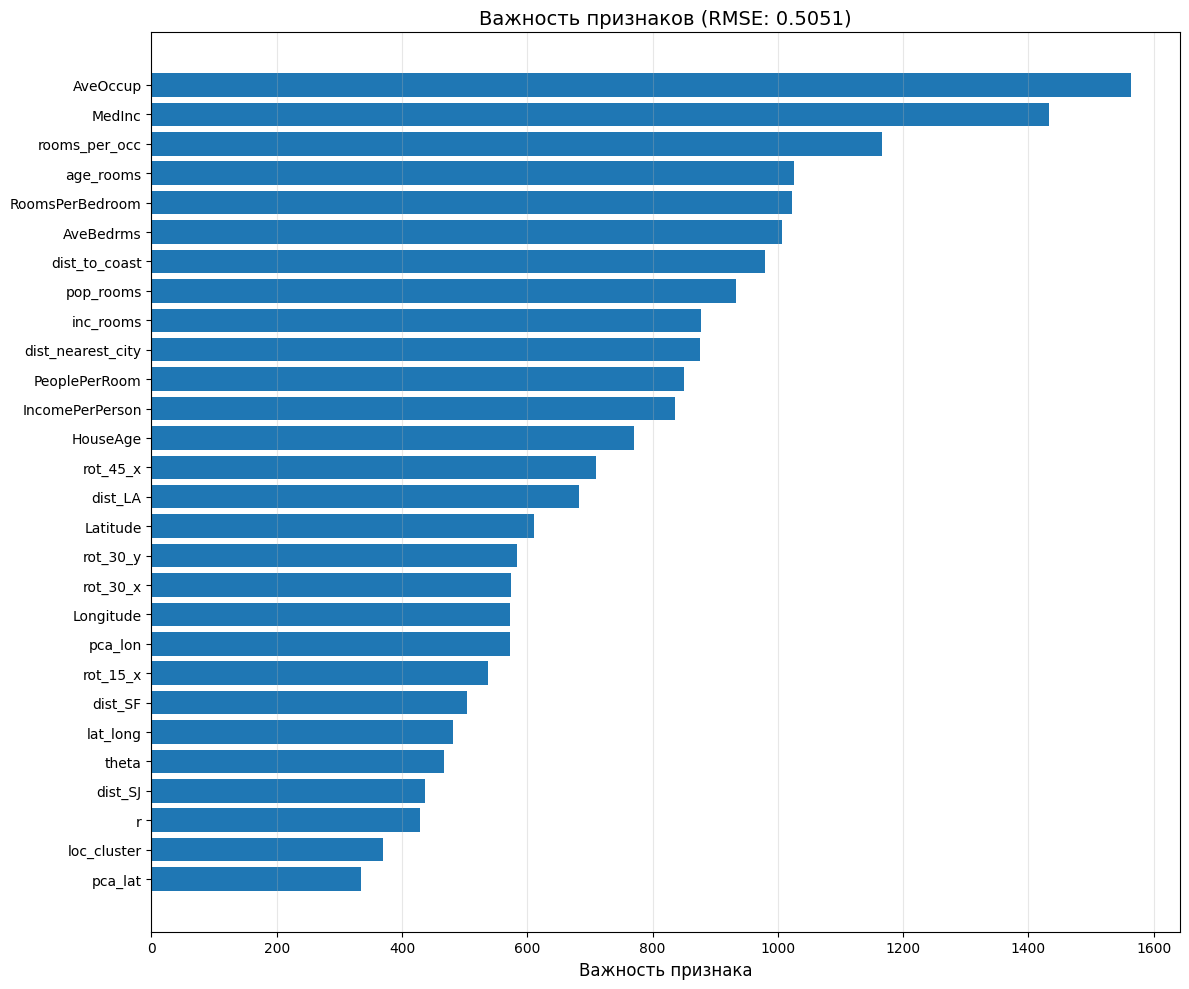


Создание submission файла...
Submission файл сохранен: submission_final_features.csv

Первые 5 строк submission:
      id  MedHouseVal
0  37137     0.675021
1  37138     1.023202
2  37139     3.817098
3  37140     3.373476
4  37141     2.515140


In [44]:
# Финальный набор признаков
final_features = [
    'MedInc', 'HouseAge', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude', 'RoomsPerBedroom', 'PeoplePerRoom', 'IncomePerPerson', 'inc_rooms', 'age_rooms', 'pop_rooms', 'lat_long', 'rooms_per_occ', 'dist_SF', 'dist_SJ', 'dist_LA', 'dist_nearest_city', 'dist_to_coast', 'rot_15_x', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'pca_lat', 'pca_lon', 'r', 'theta', 'loc_cluster'
]

print(f"Финальный набор признаков: {len(final_features)}")

# Проверяем наличие признаков в данных
missing_features = [f for f in final_features if f not in X_fe.columns]
if missing_features:
    print(f"⚠️  Отсутствуют признаки: {missing_features}")
    # Пропускаем обучение если нет признаков
else:
    # Подготовка данных
    X_final = X_fe[final_features].copy()
    y_final = y_fe.copy()

    # Параметры модели
    FINAL_MODEL_PARAMS = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'max_depth': 7,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'min_child_samples': 20,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        "early_stopping_rounds": 1000,
        'device': 'cpu'
    }

    # Обучение модели
    print("\nОбучение финальной модели...")
    final_model = LGBMRegressor(**FINAL_MODEL_PARAMS)

    # Разделение для валидации
    X_train, X_val, y_train, y_val = train_test_split(
        X_final, y_final, test_size=0.2, random_state=42
    )

    final_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    # Предсказание и оценка
    y_pred = final_model.predict(X_val)
    final_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"RMSE на валидации: {final_rmse:.4f}")

    # Вывод важности признаков
    print("\n" + "="*60)
    print("ВАЖНОСТЬ ПРИЗНАКОВ (финальная модель):")
    print("="*60)

    importance_df = pd.DataFrame({
        'feature': final_features,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nРейтинг важности признаков:")
    print("-" * 80)
    for i, row in importance_df.iterrows():
        print(f"{i+1:2d}. {row['feature']:25s}: {row['importance']:8.2f}")

    # Визуализация важности признаков
    plt.figure(figsize=(12, 10))
    plt.barh(range(len(importance_df)), importance_df['importance'][::-1])
    plt.yticks(range(len(importance_df)), importance_df['feature'][::-1])
    plt.xlabel('Важность признака', fontsize=12)
    plt.title(f'Важность признаков (RMSE: {final_rmse:.4f})', fontsize=14)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

    # Предсказание на тестовых данных
    print("\nСоздание submission файла...")
    X_test_final = X_test_processed[final_features].copy()
    test_predictions = final_model.predict(X_test_final)

    submission = pd.DataFrame({
        'id': test['id'],
        'MedHouseVal': test_predictions
    })

    submission.to_csv('submission_filtered_features.csv', index=False)
    print(f"Submission файл сохранен: submission_final_features.csv")
    print("\nПервые 5 строк submission:")
    print(submission.head())

Submission score: 0.56623 \
Скор на всех сгенерированных фичах: 0.56656

## Оптимизация гиперпараметров ##

In [51]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Убедимся, что у нас есть финальные фичи
print(f"Количество фичей для оптимизации: {len(final_features)}")

# Функция для оптимизации с KFold кросс-валидацией
def objective(trial):
    # Параметры для оптимизации
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-6, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'cpu'
    }

    # K-Fold кросс-валидация
    n_folds = 5
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_opt, y_opt)):
        # Разделение на train/val
        X_train_fold = X_opt.iloc[train_idx]
        X_val_fold = X_opt.iloc[val_idx]
        y_train_fold = y_opt.iloc[train_idx]
        y_val_fold = y_opt.iloc[val_idx]

        # Создание и обучение модели
        model = lgb.LGBMRegressor(**params)

        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric='rmse',
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )

        # Предсказание и оценка
        y_pred = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        scores.append(rmse)

    # Возвращаем средний RMSE
    return np.mean(scores)

In [ ]:
# # Создаем study для оптимизации
# if optimize:
#     study = optuna.create_study(
#         direction='minimize',
#         sampler=TPESampler(seed=42),
#         pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
#     )

#     # Запускаем оптимизацию

#     study.optimize(objective, n_trials=50, show_progress_bar=True)

#     # Выводим лучшие параметры
#     print("\n" + "="*60)
#     print("ЛУЧШИЕ ПАРАМЕТРЫ ПОСЛЕ ОПТИМИЗАЦИИ:")
#     print("="*60)
#     print(f"Лучшее значение RMSE: {study.best_value:.6f}")
#     print("\nЛучшие параметры:")
#     for key, value in study.best_params.items():
#         print(f"  {key}: {value}")

#     # Визуализация результатов оптимизации
#     print("\nВизуализация результатов оптимизации...")

#     # 1. История оптимизации
#     fig = optuna.visualization.plot_optimization_history(study)
#     fig.show()

#     # 2. Важность параметров
#     fig = optuna.visualization.plot_param_importances(study)
#     fig.show()

#     # 3. Параллельные координаты
#     fig = optuna.visualization.plot_parallel_coordinate(study)
#     fig.show()

#     # 4. Контурные графики для важных параметров
#     try:
#         fig = optuna.visualization.plot_contour(study, params=['learning_rate', 'max_depth'])
#         fig.show()
#     except:
#         print("Невозможно создать контурный график для выбранных параметров")


Оптимизация LGBM на back отобранных фичах: \
Без оптимизации (фильтрованные фичи): ~0.56623 \
С оптимизацией (кросс-валидация): 0.557422


ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ОПТИМИЗИРОВАННЫМИ ПАРАМЕТРАМИ

--- Fold 1/5 ---
RMSE fold 1: 0.502253

--- Fold 2/5 ---
RMSE fold 2: 0.518658

--- Fold 3/5 ---
RMSE fold 3: 0.509023

--- Fold 4/5 ---
RMSE fold 4: 0.531613

--- Fold 5/5 ---
RMSE fold 5: 0.515825

Средний RMSE: 0.515474 (±0.009871)

Обучение финальной модели на всех данных...

Создание сабмишена с оптимизированной моделью...
Сабмишн сохранен как 'submission_optimized.csv'

Первые 5 строк сабмишена:
      id  MedHouseVal
0  37137     0.685078
1  37138     1.019413
2  37139     3.975811
3  37140     3.072753
4  37141     2.452357

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:
Без оптимизации (фильтрованные фичи): ~0.56623
С оптимизацией (кросс-валидация): 0.515474

ВАЖНОСТЬ ПРИЗНАКОВ В ОПТИМИЗИРОВАННОЙ МОДЕЛИ:
 1. AveOccup                 :  7884.00
 2. MedInc                   :  7113.00
 3. rooms_per_occ            :  6198.00
 4. RoomsPerBedroom          :  5998.00
 5. AveBedrms                :  5886.00
 6. age_rooms                :  5708.00
 7

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (28,) and arg 3 with shape (20,).

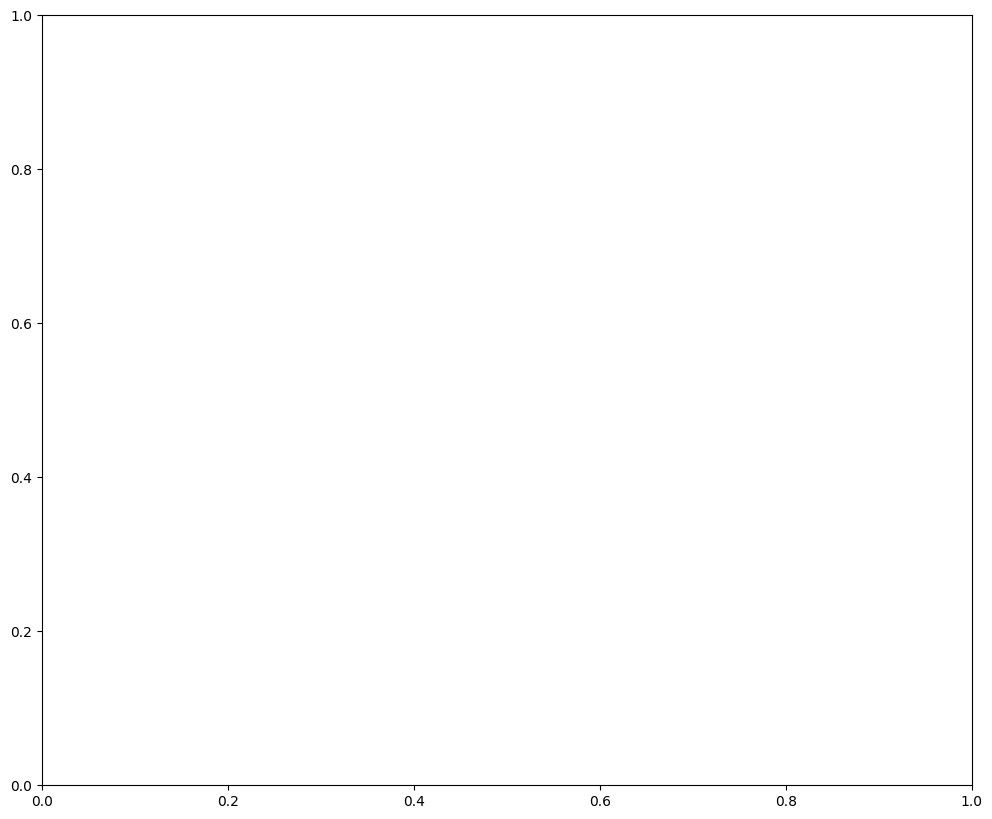

In [46]:
# Обучение финальной модели с лучшими параметрами
print("\n" + "="*60)
print("ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ОПТИМИЗИРОВАННЫМИ ПАРАМЕТРАМИ")
print("="*60)

X_opt = X_fe[final_features].copy()
y_opt = y_fe.copy()

# Добавляем фиксированные параметры к лучшим найденным
# best_params = study.best_params.copy()
best_params = {
    'n_estimators': 2215,
    'learning_rate': 0.013520507361370957,
    'max_depth': 9,
    'num_leaves': 62,
    'feature_fraction': 0.5397627836280913,
    'bagging_fraction': 0.9327876748365295,
    'bagging_freq': 7,
    'min_child_samples': 74,
    'min_child_weight': 4.8187219450969095e-06,
    'reg_alpha': 1.1511243148627115e-08,
    'reg_lambda': 0.06235292437688871,
    'subsample': 0.7108860591385846,
    'subsample_freq': 8,
    'colsample_bytree': 0.7970446203888105
}
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
})

# Обучаем финальную модель на всех данных
final_model_optimized = lgb.LGBMRegressor(**best_params)

# Используем 5-кратную кросс-валидацию для оценки
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
cv_scores = []
cv_models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_opt, y_opt)):
    print(f"\n--- Fold {fold+1}/{n_folds} ---")

    X_train_fold = X_opt.iloc[train_idx]
    X_val_fold = X_opt.iloc[val_idx]
    y_train_fold = y_opt.iloc[train_idx]
    y_val_fold = y_opt.iloc[val_idx]

    model = lgb.LGBMRegressor(**best_params)

    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )

    y_pred = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    cv_scores.append(rmse)
    cv_models.append(model)

    print(f"RMSE fold {fold+1}: {rmse:.6f}")

print(f"\nСредний RMSE: {np.mean(cv_scores):.6f} (±{np.std(cv_scores):.6f})")

# Обучаем модель на всех данных для сабмишена
print("\nОбучение финальной модели на всех данных...")
final_model_full = lgb.LGBMRegressor(**best_params)
final_model_full.fit(
    X_opt, y_opt,
    eval_metric='rmse',
    callbacks=[lgb.log_evaluation(period=0)]
)

# Создаем сабмишн с оптимизированной моделью
print("\nСоздание сабмишена с оптимизированной моделью...")
X_test_final_opt = X_test_processed[final_features].copy()
test_predictions_opt = final_model_full.predict(X_test_final_opt)

submission_opt = pd.DataFrame({
    'id': test['id'],
    'MedHouseVal': test_predictions_opt
})

submission_opt.to_csv('submission_optimized_lgbm.csv', index=False)
print("Сабмишн сохранен как 'submission_optimized.csv'")
print("\nПервые 5 строк сабмишена:")
print(submission_opt.head())

# Сравнение с предыдущими результатами
print("\n" + "="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print("="*60)
print(f"Без оптимизации (фильтрованные фичи): ~0.56623")
print(f"С оптимизацией (кросс-валидация): {np.mean(cv_scores):.6f}")

# Анализ важности фич в оптимизированной модели
print("\n" + "="*60)
print("ВАЖНОСТЬ ПРИЗНАКОВ В ОПТИМИЗИРОВАННОЙ МОДЕЛИ:")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': final_model_full.feature_importances_
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f"{i:2d}. {row['feature']:25s}: {row['importance']:8.2f}")

# Визуализация важности признаков
plt.figure(figsize=(12, 10))
plt.barh(range(20), feature_importance['importance'][::-1])
plt.yticks(range(20), feature_importance['feature'][::-1])
plt.xlabel('Важность признака', fontsize=12)
plt.title(f'Важность признаков (оптимизированная модель)', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Сохраняем лучшие параметры в файл
if optimize:
    import json
    with open('best_params.json', 'w') as f:
        json.dump(study.best_params, f, indent=2)
    print("\nЛучшие параметры сохранены в 'best_params.json'")

## Оптимизация XGB через Optuna с отобранным набором фич ##

In [ ]:
def objective_xgb_fixed(trial):
    """Исправленная целевая функция для оптимизации XGBoost"""

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),

        # Параметры для CPU
        'tree_method': 'hist', # Use 'hist' for CPU-based histogram algorithm
        'max_bin': trial.suggest_int('max_bin', 64, 512),

        'eval_metric': 'rmse',  # eval_metric должен быть в параметрах!
        'objective': 'reg:squarederror',
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': -1 # Use all available CPU cores
    }

    # K-Fold кросс-валидация
    n_folds = 3  # Меньше фолдов для скорости
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_xgb, y_xgb)):
        # Разделение данных
        X_train_fold = X_xgb.iloc[train_idx]
        X_val_fold = X_xgb.iloc[val_idx]
        y_train_fold = y_xgb.iloc[train_idx]
        y_val_fold = y_xgb.iloc[val_idx]

        # Обучение модели - ВАЖНО: eval_metric в параметрах, а не в fit!
        model = xgb.XGBRegressor(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )

        # Предсказание и оценка
        y_pred = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        scores.append(rmse)

    return np.mean(scores)

In [ ]:
# import xgboost as xgb

# X_xgb = X_fe[final_features].copy() if 'final_features' in locals() else X_fe.copy()
# y_xgb = y_fe.copy()

# # Создаем study для XGBoost
# study_xgb = optuna.create_study(
#     direction='minimize',
#     sampler=TPESampler(seed=42),
#     pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
# )

# print("Начинаем оптимизацию XGBoost (20 trials для скорости)...")
# study_xgb.optimize(objective_xgb_fixed, n_trials=30, show_progress_bar=True)

# # Выводим лучшие параметры
# print("\n" + "="*80)
# print("ЛУЧШИЕ ПАРАМЕТРЫ XGBOOST:")
# print("="*80)
# print(f"Лучшее значение RMSE: {study_xgb.best_value:.6f}")
# print("\nЛучшие параметры:")
# for key, value in study_xgb.best_params.items():
#     print(f"  {key}: {value}")

===========================================================
ЛУЧШИЕ ПАРАМЕТРЫ XGBOOST: \

Лучшее значение RMSE: 0.518164\

Лучшие параметры:\
  n_estimators: 1670\
  learning_rate: 0.019108940882969657\
  max_depth: 10\
  min_child_weight: 9.869423127379529\
  subsample: 0.5592676197711589\
  colsample_bytree: 0.5337855469870452\
  gamma: 0.3934399780396621\
  reg_alpha: 6.796950569584555\
  reg_lambda: 6.716803057762461\
  max_bin: 373

In [48]:
import xgboost as xgb

# Обучение финальной модели XGBoost с лучшими параметрами
print("\nОбучение финальной модели XGBoost...")

X_xgb = X_fe[final_features].copy() if 'final_features' in locals() else X_fe.copy()
y_xgb = y_fe.copy()

# Добавляем фиксированные параметры
best_params_xgb = {
    'n_estimators': 1670,
    'learning_rate': 0.019108940882969657,
    'max_depth': 10,
    'min_child_weight': 9.869423127379529,
    'subsample': 0.5592676197711589,
    'colsample_bytree': 0.5337855469870452,
    'gamma': 0.3934399780396621,
    'reg_alpha': 6.796950569584555,
    'reg_lambda': 6.716803057762461,
    'max_bin': 373
}

best_params_xgb.update({
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'verbosity': 0,
    'n_jobs': -1, # Use all available CPU cores
    'tree_method': 'hist' # Ensure CPU tree method is specified
})

# Разделяем данные для обучения с early stopping
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

# Обучение с early stopping
final_model_xgb = xgb.XGBRegressor(**best_params_xgb)
final_model_xgb.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)

print("✓ XGBoost модель обучена")


Обучение финальной модели XGBoost...
✓ XGBoost модель обучена


In [49]:
X_test_xgb = X_test_processed[X_xgb.columns].copy()
xgb_predictions = final_model_xgb.predict(X_test_xgb)

submission_xgb_optimized = pd.DataFrame({
    'id': test['id'],
    'MedHouseVal': xgb_predictions
})

submission_xgb_optimized.to_csv('submission_xgb_optimized.csv', index=False)
print("submission_xgb_optimized.csv создан!")

submission_xgb_optimized.csv создан!


In [52]:
optimize = True

## Оптимизация CatBoost через Optuna с отобранным набором фич ##

In [68]:
pip install catboost -q

from catboost import CatBoostRegressor
import warnings
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

warnings.filterwarnings('ignore')

print("\n" + "="*60)
print("ОПТИМИЗАЦИЯ CATBOOST С ПОМОЩЬЮ OPTUNA")
print("="*60)

# Используем фичи от forward selection для оптимизации

def objective_cat(trial):
    """Целевая функция для оптимизации CatBoost"""

    params = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),

        # Параметр grow_policy теперь зависит от других параметров
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),

        # Параметр bootstrap_type нужно обрабатывать отдельно
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),

        # Основные параметры
        'loss_function': 'RMSE',
        'random_seed': 42,
        'verbose': False,
        'allow_writing_files': False,
        'thread_count': -1  # Использовать все доступные ядра CPU
    }

    # Обработка параметра leaf_estimation_iterations
    params['leaf_estimation_iterations'] = trial.suggest_int('leaf_estimation_iterations', 1, 10)

    # Обработка параметра bootstrap_type и связанных параметров
    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 10.0)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)

    # K-Fold кросс-валидация
    n_folds = 3
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_cat, y_cat):
        # Разделение данных
        X_train_fold = X_cat.iloc[train_idx]
        X_val_fold = X_cat.iloc[val_idx]
        y_train_fold = y_cat.iloc[train_idx]
        y_val_fold = y_cat.iloc[val_idx]

        # Обучение модели
        model = CatBoostRegressor(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=(X_val_fold, y_val_fold),
            early_stopping_rounds=100,
            verbose=False
        )

        # Предсказание и оценка
        y_pred = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        scores.append(rmse)

    return np.mean(scores)


ОПТИМИЗАЦИЯ CATBOOST С ПОМОЩЬЮ OPTUNA


In [69]:
if optimize:
    X_cat = X_fe[final_features].copy() if 'final_features' in locals() else X_fe.copy()
    y_cat = y_fe.copy()
    # Создаем study для CatBoost
    study_cat = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )

    print("Начинаем оптимизацию CatBoost...")
    study_cat.optimize(objective_cat, n_trials=30, show_progress_bar=True)  # Меньше trials для скорости

    # Выводим лучшие параметры
    print("\n" + "="*60)
    print("ЛУЧШИЕ ПАРАМЕТРЫ CATBOOST:")
    print("="*60)
    print(f"Лучшее значение RMSE: {study_cat.best_value:.6f}")
    print("\nЛучшие параметры:")
    for key, value in study_cat.best_params.items():
        print(f"  {key}: {value}")

    # Визуализация результатов оптимизации CatBoost
    print("\nВизуализация результатов оптимизации CatBoost...")

    fig1 = optuna.visualization.plot_optimization_history(study_cat)
    fig1.show()

    fig2 = optuna.visualization.plot_param_importances(study_cat)
    fig2.show()


[I 2025-12-15 08:09:39,444] A new study created in memory with name: no-name-093c36be-f68d-49b9-bbd1-713999713169


Начинаем оптимизацию CatBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-15 08:10:10,406] Trial 0 finished with value: 0.5415913777469759 and parameters: {'iterations': 1436, 'learning_rate': 0.2536999076681772, 'depth': 8, 'l2_leaf_reg': 0.0024430162614261413, 'random_strength': 2.5361081166471375e-07, 'border_count': 66, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'leaf_estimation_iterations': 1, 'subsample': 0.9849549260809971}. Best is trial 0 with value: 0.5415913777469759.
[I 2025-12-15 08:12:05,979] Trial 1 finished with value: 0.5461643367239611 and parameters: {'iterations': 2581, 'learning_rate': 0.020589728197687916, 'depth': 4, 'l2_leaf_reg': 4.4734294104626844e-07, 'random_strength': 5.472429642032198e-06, 'border_count': 149, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'leaf_estimation_iterations': 3, 'bagging_temperature': 3.663618432936917}. Best is trial 0 with value: 0.5415913777469759.
[I 2025-12-15 08:12:43,922] Trial 2 finished with value: 0.5274676234283139 and parameters: {'iterations': 1640

============================================================ \
ЛУЧШИЕ ПАРАМЕТРЫ CATBOOST:\
============================================================\
Лучшее значение RMSE: 0.519448\

Лучшие параметры:\
  iterations: 1867\
  learning_rate: 0.01875220945578641\
  depth: 10\
  l2_leaf_reg: 0.09466630153726856\
  random_strength: 2.854239907497756\
  border_count: 232\
  grow_policy: Depthwise\
  bootstrap_type: Bernoulli\
  leaf_estimation_iterations: 1\
  subsample: 0.6626651653816322\

In [ ]:
if optimize:
    print(study_cat.best_params)

In [ ]:
!pip install catboost -q

from catboost import CatBoostRegressor
import json

# Обучение финальной модели CatBoost с лучшими параметрами
print("\nОбучение финальной модели CatBoost...")

X_cat = X_fe[final_features].copy() if 'final_features' in locals() else X_fe.copy()
y_cat = y_fe.copy()

# Добавляем фиксированные параметры
best_params_cat = {
    'iterations': 15000,
    'learning_rate': 0.007875220945578641,
    'depth': 10,
    'l2_leaf_reg': 0.09466630153726856,
    'random_strength': 2.854239907497756,
    'border_count': 232,
    'grow_policy': 'Depthwise',
    'bootstrap_type': 'Bernoulli',
    'leaf_estimation_iterations': 1,
    'subsample': 0.6626651653816322
}
best_params_cat.update({
    'random_seed': 42,
    'verbose': False,
    'allow_writing_files': False,
    'task_type': 'CPU'
})

# Кросс-валидация для оценки (3 фолда для скорости)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cat_scores = []
cat_models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_cat, y_cat)):
    print(f"\n--- Fold {fold+1}/3 ---")

    X_train_fold = X_cat.iloc[train_idx]
    X_val_fold = X_cat.iloc[val_idx]
    y_train_fold = y_cat.iloc[train_idx]
    y_val_fold = y_cat.iloc[val_idx]

    model = CatBoostRegressor(**best_params_cat)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        early_stopping_rounds=100,
        verbose=False
    )

    y_pred = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    cat_scores.append(rmse)
    cat_models.append(model)

    print(f"RMSE fold {fold+1}: {rmse:.6f}")

print(f"\nСредний RMSE CatBoost: {np.mean(cat_scores):.6f} (±{np.std(cat_scores):.6f})")

# Обучаем на всех данных для сабмишена
print("\nОбучение CatBoost на всех данных...")
final_model_cat = CatBoostRegressor(**best_params_cat)
final_model_cat.fit(X_cat, y_cat, verbose=False)

# Сохраняем лучшие параметры
with open('best_params_cat.json', 'w') as f:
    json.dump(best_params_cat, f, indent=2)
print("Лучшие параметры CatBoost сохранены в 'best_params_cat.json'")


Обучение финальной модели CatBoost...

--- Fold 1/3 ---
RMSE fold 1: 0.511961

--- Fold 2/3 ---
RMSE fold 2: 0.520126

--- Fold 3/3 ---
RMSE fold 3: 0.522126

Средний RMSE CatBoost: 0.518071 (±0.004397)

Обучение CatBoost на всех данных...


In [ ]:
X_test_cat = X_test_processed[X_cat.columns].copy()
xcat_predictions = final_model_cat.predict(X_test_cat)

submission_xcat_optimized = pd.DataFrame({
    'id': test['id'],
    'MedHouseVal': xcat_predictions
})

submission_xgb_optimized.to_csv('submission_cat_optimized_15r.csv', index=False)
print("submission_cat_optimized.csv создан!")

## Ансамблирование ##

In [58]:
print("\n" + "="*80)
print("АНСАМБЛИРОВАНИЕ МОДЕЛЕЙ")
print("="*80)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold
import numpy as np

class EnsembleModel:
    """Класс для ансамблирования моделей"""

    def __init__(self, models, ensemble_method='weighted_average', meta_model=None):
        """
        Инициализация ансамбля

        Parameters:
        -----------
        models : dict
            Словарь моделей {имя: модель}
        ensemble_method : str
            Метод ансамблирования: 'weighted_average', 'stacking', 'voting'
        meta_model : object
            Мета-модель для стекинга
        """
        self.models = models
        self.ensemble_method = ensemble_method
        self.meta_model = meta_model
        self.weights = None
        self.meta_model_trained = None

    def fit(self, X, y, cv_folds=5):
        """Обучение ансамбля"""

        if self.ensemble_method == 'weighted_average':
            # Определяем оптимальные веса с помощью кросс-валидации
            self._fit_weighted_average(X, y, cv_folds)

        elif self.ensemble_method == 'stacking':
            # Обучение стекинга
            self._fit_stacking(X, y, cv_folds)

        elif self.ensemble_method == 'voting':
            # Простое голосование (среднее)
            self.weights = {name: 1/len(self.models) for name in self.models}

        # Обучаем все базовые модели на полных данных
        for name, model in self.models.items():
            model.fit(X, y)

        return self

    def _fit_weighted_average(self, X, y, cv_folds=5):
        """Оптимизация весов для взвешенного среднего"""

        kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
        n_models = len(self.models)

        # Собираем предсказания на кросс-валидации
        cv_predictions = {name: [] for name in self.models}
        cv_targets = []

        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Обучаем каждую модель на тренировочной части фолда
            for name, model in self.models.items():
                # Создаем копию модели для обучения
                model_copy = self._clone_model(model)
                model_copy.fit(X_train, y_train)

                # Предсказание на валидации
                y_pred = model_copy.predict(X_val)
                cv_predictions[name].extend(y_pred)

            cv_targets.extend(y_val)

        # Преобразуем в numpy массивы
        cv_pred_array = np.column_stack([cv_predictions[name] for name in self.models])
        cv_target_array = np.array(cv_targets)

        # Оптимизируем веса с помощью Ridge регрессии
        ridge = Ridge(alpha=1.0, positive=True, random_state=42)
        ridge.fit(cv_pred_array, cv_target_array)

        # Нормализуем веса, чтобы сумма была равна 1
        weights = ridge.coef_
        weights = np.maximum(weights, 0)  # Делаем веса неотрицательными
        if weights.sum() > 0:
            weights = weights / weights.sum()
        else:
            weights = np.ones(n_models) / n_models

        self.weights = {name: weight for name, weight in zip(self.models.keys(), weights)}

        print("Оптимальные веса для взвешенного среднего:")
        for name, weight in self.weights.items():
            print(f"  {name}: {weight:.4f}")

    def _fit_stacking(self, X, y, cv_folds=5):
        """Обучение стекинга"""

        kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
        n_models = len(self.models)

        # Матрица для предсказаний базовых моделей
        X_meta_train = np.zeros((len(X), n_models))

        # Собираем out-of-fold предсказания
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train = y.iloc[train_idx]

            for i, (name, model) in enumerate(self.models.items()):
                model_copy = self._clone_model(model)
                model_copy.fit(X_train, y_train)

                # Предсказание на валидационной части
                X_meta_train[val_idx, i] = model_copy.predict(X_val)

        # Обучаем мета-модель
        if self.meta_model is None:
            self.meta_model = Ridge(alpha=1.0, random_state=42)

        self.meta_model_trained = self.meta_model.fit(X_meta_train, y)

        print("Коэффициенты мета-модели (стекинг):")
        for name, coef in zip(self.models.keys(), self.meta_model_trained.coef_):
            print(f"  {name}: {coef:.4f}")

        print(f"Интерсепт: {self.meta_model_trained.intercept_:.4f}")

    def _clone_model(self, model):
        """Создает копию модели"""
        from sklearn.base import clone
        return clone(model)

    def predict(self, X):
        """Предсказание ансамбля"""

        if self.ensemble_method == 'weighted_average':
            predictions = np.zeros(len(X))

            for name, model in self.models.items():
                weight = self.weights[name]
                predictions += weight * model.predict(X)

            return predictions

        elif self.ensemble_method == 'stacking':
            # Предсказания базовых моделей
            base_predictions = np.column_stack([
                model.predict(X) for model in self.models.values()
            ])

            # Предсказание мета-модели
            return self.meta_model_trained.predict(base_predictions)

        elif self.ensemble_method == 'voting':
            # Простое среднее
            predictions = np.zeros(len(X))

            for model in self.models.values():
                predictions += model.predict(X)

            return predictions / len(self.models)

    def evaluate(self, X, y):
        """Оценка ансамбля"""
        y_pred = self.predict(X)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        return rmse


АНСАМБЛИРОВАНИЕ МОДЕЛЕЙ


In [61]:
best_params_lgb = {
    'n_estimators': 2215,
    'learning_rate': 0.013520507361370957,
    'max_depth': 9,
    'num_leaves': 62,
    'feature_fraction': 0.5397627836280913,
    'bagging_fraction': 0.9327876748365295,
    'bagging_freq': 7,
    'min_child_samples': 74,
    'min_child_weight': 4.8187219450969095e-06,
    'reg_alpha': 1.1511243148627115e-08,
    'reg_lambda': 0.06235292437688871,
    'subsample': 0.7108860591385846,
    'subsample_freq': 8,
    'colsample_bytree': 0.7970446203888105
}
best_params_lgb.update({
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
})

best_params_xgb = {
    'n_estimators': 1670,
    'learning_rate': 0.019108940882969657,
    'max_depth': 10,
    'min_child_weight': 9.869423127379529,
    'subsample': 0.5592676197711589,
    'colsample_bytree': 0.5337855469870452,
    'gamma': 0.3934399780396621,
    'reg_alpha': 6.796950569584555,
    'reg_lambda': 6.716803057762461,
    'max_bin': 373
}

best_params_xgb.update({
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'verbosity': 0,
    'n_jobs': -1,
    'tree_method': 'hist'
})

best_params_cat = {
    'iterations': 1867,
    'learning_rate': 0.01875220945578641,
    'depth': 10,
    'l2_leaf_reg': 0.09466630153726856,
    'random_strength': 2.854239907497756,
    'border_count': 232,
    'grow_policy': 'Depthwise',
    'bootstrap_type': 'Bernoulli',
    'leaf_estimation_iterations': 1,
    'subsample': 0.6626651653816322
}
best_params_cat.update({
    'random_seed': 42,
    'verbose': False,
    'allow_writing_files': False,
    'task_type': 'CPU'
})



In [64]:
import xgboost as xgb


X_ensemble = X_fe[final_features].copy() if 'final_features' in locals() else X_fe.copy()
y_ensemble = y_fe.copy()

print(f"Размер данных для ансамблирования: {X_ensemble.shape}")

optimized_models = {
    'LightGBM': lgb.LGBMRegressor(**best_params_lgb),
    'XGBoost': xgb.XGBRegressor(**best_params_xgb),
    'CatBoost': CatBoostRegressor(**best_params_cat)
}

for name, model in optimized_models.items():
    if not hasattr(model, 'predict'):
        print(f"⚠️  Модель {name} не обучена. Обучаем...")
        model.fit(X_ensemble, y_ensemble)

print(f"\nГотовы к ансамблированию {len(optimized_models)} моделей")

Подготовка данных для ансамблирования...
Размер данных для ансамблирования: (57777, 28)

Готовы к ансамблированию 3 моделей



--------------------------------------------------------------------------------
ТЕСТИРОВАНИЕ РАЗНЫХ МЕТОДОВ АНСАМБЛИРОВАНИЯ
--------------------------------------------------------------------------------
Train size: (46221, 28), Test size: (11556, 28)

1. Взвешенное среднее (Weighted Average):
Оптимальные веса для взвешенного среднего:
  LightGBM: 0.3384
  XGBoost: 0.3343
  CatBoost: 0.3273
RMSE взвешенного ансамбля: 0.501158

2. Стекинг (Stacking) с Ridge регрессией:
Коэффициенты мета-модели (стекинг):
  LightGBM: 0.3728
  XGBoost: 0.3331
  CatBoost: 0.2952
Интерсепт: -0.0030
RMSE стекинга: 0.501102

3. Простое среднее (Voting):
RMSE простого среднего: 0.501170

--------------------------------------------------------------------------------
СРАВНЕНИЕ ОТДЕЛЬНЫХ МОДЕЛЕЙ НА ТЕСТОВОМ НАБОРЕ
--------------------------------------------------------------------------------
LightGBM: 0.502569
XGBoost: 0.502834
CatBoost: 0.506092

ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МЕТОДОВ

Рейтинг методов (лучшие св

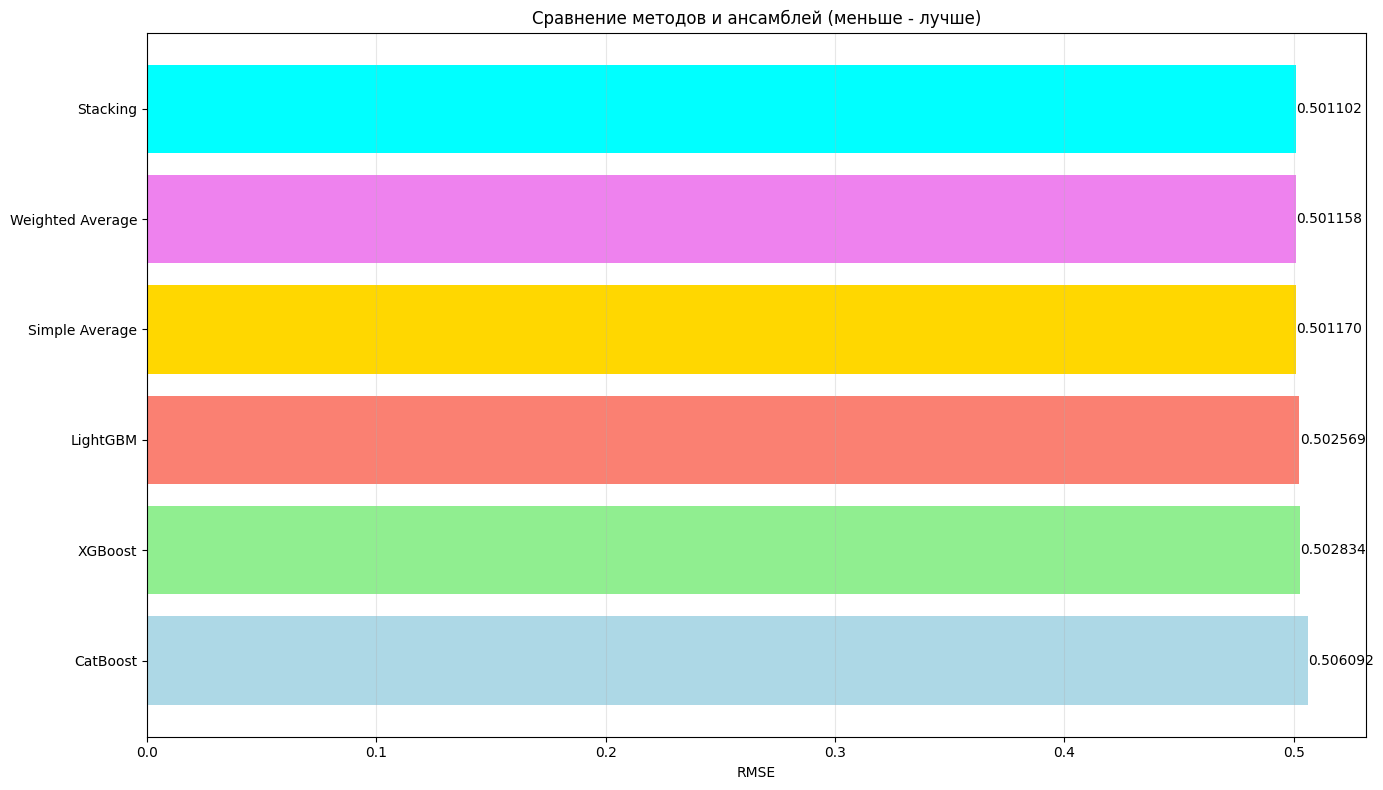


🏆 ЛУЧШИЙ МЕТОД: Stacking с RMSE = 0.501102

ОБУЧЕНИЕ ЛУЧШЕГО АНСАМБЛЯ (Stacking) НА ВСЕХ ДАННЫХ
Коэффициенты мета-модели (стекинг):
  LightGBM: 0.4490
  XGBoost: 0.3330
  CatBoost: 0.2189
Интерсепт: -0.0026

Создание финального сабмишена...

Сохранение сабмишенов от всех моделей...

Сабмишены сохранены:
  - submission_lightgbm.csv (LightGBM)
  - submission_xgboost.csv (XGBoost)
  - submission_catboost.csv (CatBoost)
  - submission_final_ensemble.csv (Stacking)

Первые 5 строк финального сабмишена:
      id  MedHouseVal
0  37137     0.676879
1  37138     1.013711
2  37139     3.922751
3  37140     3.186572
4  37141     2.458347

АНАЛИЗ СОГЛАСОВАННОСТИ ПРЕДСКАЗАНИЙ МОДЕЛЕЙ

Корреляция между предсказаниями моделей:
--------------------------------------------------------------------------------
          LightGBM  XGBoost  CatBoost  Ensemble
LightGBM    1.0000   0.9967    0.9957    0.9993
XGBoost     0.9967   1.0000    0.9951    0.9978
CatBoost    0.9957   0.9951    1.0000    0.9978
Ense

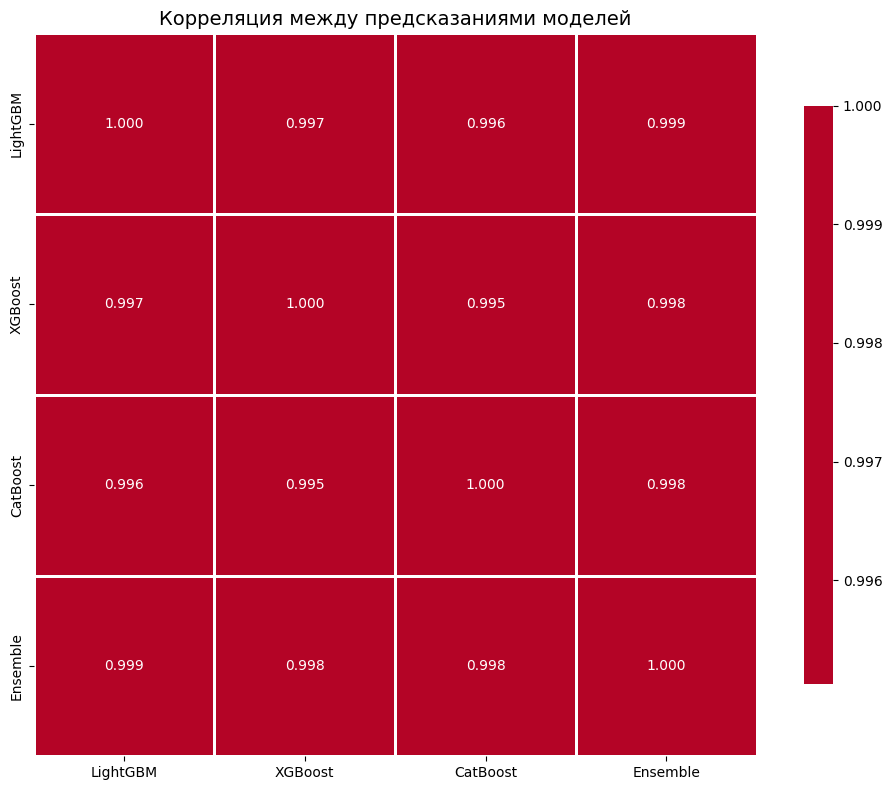


Анализ разброса предсказаний:
--------------------------------------------------------------------------------
LightGBM       : std = 1.0249
XGBoost        : std = 1.0242
CatBoost       : std = 1.0266
Ensemble       : std = 1.0248


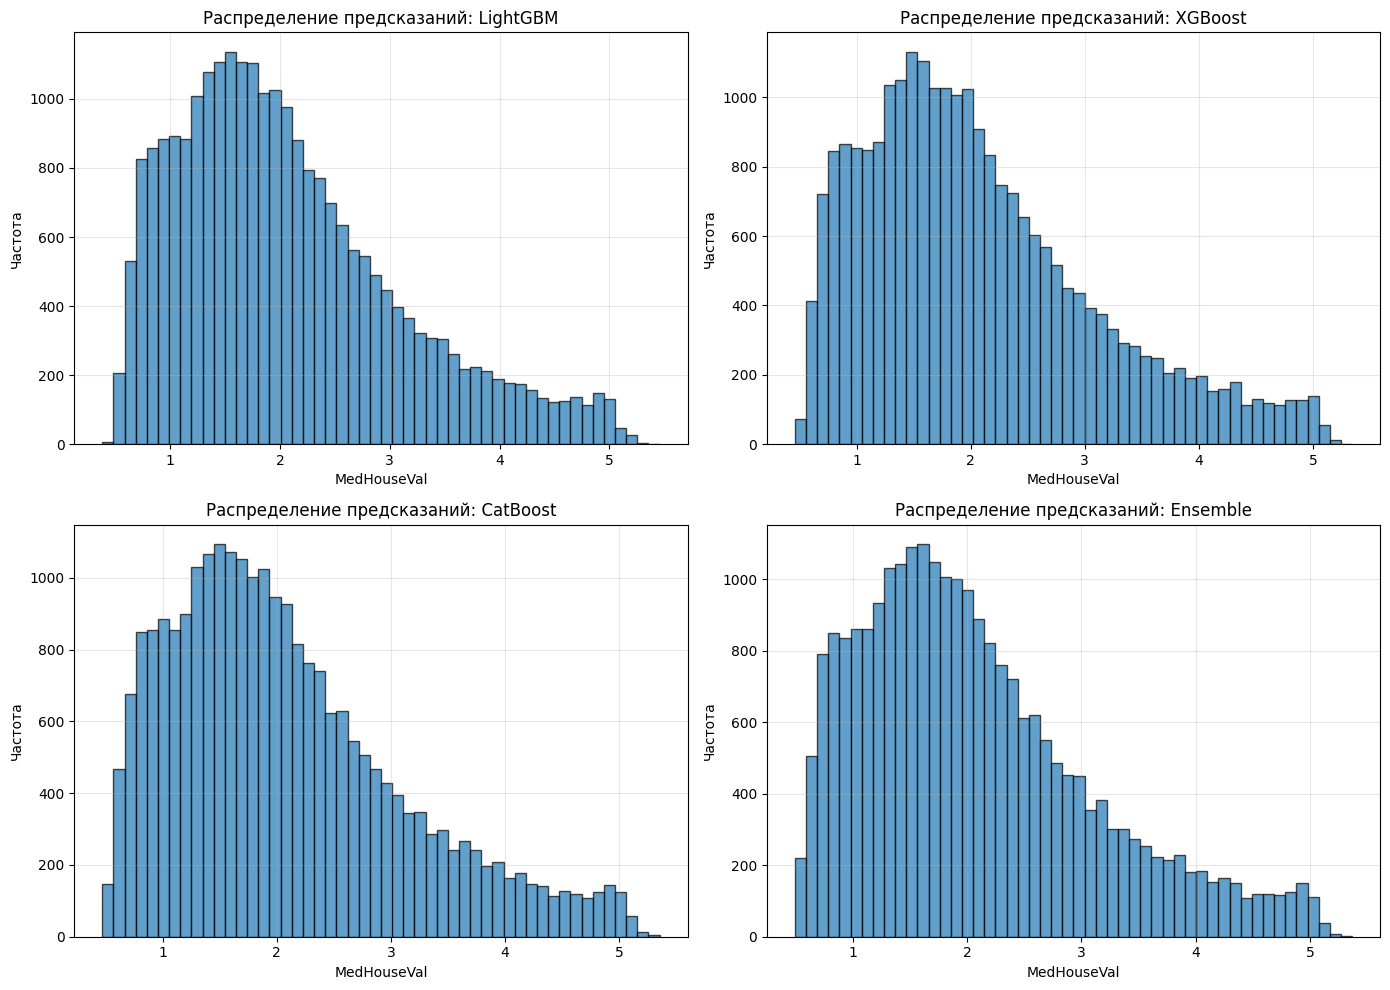

In [65]:
print("\n" + "-"*80)
print("ТЕСТИРОВАНИЕ РАЗНЫХ МЕТОДОВ АНСАМБЛИРОВАНИЯ")
print("-"*80)

from sklearn.model_selection import train_test_split
X_ens_train, X_ens_test, y_ens_train, y_ens_test = train_test_split(
    X_ensemble, y_ensemble, test_size=0.2, random_state=42
)

print(f"Train size: {X_ens_train.shape}, Test size: {X_ens_test.shape}")

print("\n1. Взвешенное среднее (Weighted Average):")
ensemble_weighted = EnsembleModel(optimized_models, ensemble_method='weighted_average')
ensemble_weighted.fit(X_ens_train, y_ens_train, cv_folds=5)

weighted_rmse = ensemble_weighted.evaluate(X_ens_test, y_ens_test)
print(f"RMSE взвешенного ансамбля: {weighted_rmse:.6f}")

print("\n2. Стекинг (Stacking) с Ridge регрессией:")
ensemble_stacking = EnsembleModel(optimized_models, ensemble_method='stacking', meta_model=Ridge(alpha=1.0))
ensemble_stacking.fit(X_ens_train, y_ens_train, cv_folds=5)

stacking_rmse = ensemble_stacking.evaluate(X_ens_test, y_ens_test)
print(f"RMSE стекинга: {stacking_rmse:.6f}")

print("\n3. Простое среднее (Voting):")
ensemble_voting = EnsembleModel(optimized_models, ensemble_method='voting')
ensemble_voting.fit(X_ens_train, y_ens_train)

voting_rmse = ensemble_voting.evaluate(X_ens_test, y_ens_test)
print(f"RMSE простого среднего: {voting_rmse:.6f}")

individual_results = []
for name, model in optimized_models.items():
    y_pred = model.predict(X_ens_test)
    rmse = np.sqrt(mean_squared_error(y_ens_test, y_pred))
    individual_results.append({
        'Модель': name,
        'RMSE': rmse
    })
    print(f"{name}: {rmse:.6f}")

print("\n" + "="*80)
print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МЕТОДОВ")
print("="*80)

all_results = individual_results + [
    {'Модель': 'Weighted Average', 'RMSE': weighted_rmse},
    {'Модель': 'Stacking', 'RMSE': stacking_rmse},
    {'Модель': 'Simple Average', 'RMSE': voting_rmse}
]

results_df = pd.DataFrame(all_results).sort_values('RMSE')

print("\nРейтинг методов (лучшие сверху):")
print("-" * 80)
for i, (_, row) in enumerate(results_df.iterrows(), 1):
    improvement = (results_df['RMSE'].iloc[0] - row['RMSE']) / results_df['RMSE'].iloc[0] * 100
    marker = "🏆" if i == 1 else f"{i}"
    print(f"{marker:3s} {row['Модель']:20s}: {row['RMSE']:.6f} "
          f"(отставание от лучшего: {improvement:+.2f}%)")

plt.figure(figsize=(14, 8))

colors = ['lightblue', 'lightgreen', 'salmon', 'gold', 'violet', 'cyan']

bars = plt.barh(range(len(results_df)), results_df['RMSE'][::-1], color=colors[:len(results_df)])

plt.yticks(range(len(results_df)), results_df['Модель'][::-1])
plt.xlabel('RMSE')
plt.title('Сравнение методов и ансамблей (меньше - лучше)')
plt.grid(True, alpha=0.3, axis='x')

for i, (bar, rmse) in enumerate(zip(bars, results_df['RMSE'][::-1])):
    plt.text(rmse + 0.0001, i, f'{rmse:.6f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Выбор лучшего метода для сабмишена
best_method = results_df.iloc[0]['Модель']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\n🏆 ЛУЧШИЙ МЕТОД: {best_method} с RMSE = {best_rmse:.6f}")

print("\n" + "="*80)
print(f"ОБУЧЕНИЕ ЛУЧШЕГО АНСАМБЛЯ ({best_method}) НА ВСЕХ ДАННЫХ")
print("="*80)

# Выбираем лучший ансамбль
if best_method == 'Weighted Average':
    best_ensemble = ensemble_weighted
    # Переобучаем на всех данных
    best_ensemble.fit(X_ensemble, y_ensemble, cv_folds=5)

elif best_method == 'Stacking':
    best_ensemble = ensemble_stacking
    best_ensemble.fit(X_ensemble, y_ensemble, cv_folds=5)

elif best_method == 'Simple Average':
    best_ensemble = ensemble_voting
    best_ensemble.fit(X_ensemble, y_ensemble)

else:
    # Если лучшая модель - одиночная, используем ее
    best_ensemble = optimized_models[best_method]
    print(f"Используем одиночную модель: {best_method}")

# Создание сабмишена всех ансамблей
print("\nСоздание финального сабмишена...")

# Подготавливаем тестовые данные
X_test_ensemble = X_test_processed[final_features].copy() if 'final_features' in locals() else X_test_processed.copy()

# Проверяем, что все признаки есть в тестовых данных
missing_in_test = set(X_ensemble.columns) - set(X_test_ensemble.columns)
if missing_in_test:
    print(f"  Добавляем отсутствующие признаки в тестовые данные: {missing_in_test}")
    for feature in missing_in_test:
        X_test_ensemble[feature] = 0

X_test_ensemble = X_test_ensemble[X_ensemble.columns]

# Предсказание
if hasattr(best_ensemble, 'predict'):
    # Это ансамбль
    test_predictions_final = best_ensemble.predict(X_test_ensemble)
else:
    # Это одиночная модель
    test_predictions_final = best_ensemble.predict(X_test_ensemble)

# Создание сабмишена
submission_final = pd.DataFrame({
    'id': test['id'],
    'MedHouseVal': test_predictions_final
})

# Сохраняем сабмишены от всех моделей для анализа
print("\nСохранение сабмишенов от всех моделей...")

# LightGBM сабмишен
if 'final_model_full' in locals():
    submission_lgb = pd.DataFrame({
        'id': test['id'],
        'MedHouseVal': final_model_full.predict(X_test_ensemble)
    })
    submission_lgb.to_csv('submission_lightgbm.csv', index=False)

# XGBoost сабмишен
submission_xgb = pd.DataFrame({
    'id': test['id'],
    'MedHouseVal': final_model_xgb.predict(X_test_ensemble)
})
submission_xgb.to_csv('submission_xgboost.csv', index=False)

# CatBoost сабмишен
submission_cat = pd.DataFrame({
    'id': test['id'],
    'MedHouseVal': final_model_cat.predict(X_test_ensemble)
})
submission_cat.to_csv('submission_catboost.csv', index=False)

# Финальный сабмишен
submission_final.to_csv('submission_final_ensemble.csv', index=False)

print("\nСабмишены сохранены:")
print("  - submission_lightgbm.csv (LightGBM)")
print("  - submission_xgboost.csv (XGBoost)")
print("  - submission_catboost.csv (CatBoost)")
print(f"  - submission_final_ensemble.csv ({best_method})")

print("\nПервые 5 строк финального сабмишена:")
print(submission_final.head())

# Анализ согласованности предсказаний моделей
print("\n" + "="*80)
print("АНАЛИЗ СОГЛАСОВАННОСТИ ПРЕДСКАЗАНИЙ МОДЕЛЕЙ")
print("="*80)

# Собираем предсказания всех моделей
predictions_dict = {
    'LightGBM': final_model_full.predict(X_test_ensemble) if 'final_model_full' in locals() else None,
    'XGBoost': final_model_xgb.predict(X_test_ensemble),
    'CatBoost': final_model_cat.predict(X_test_ensemble),
    'Ensemble': test_predictions_final
}

# Удаляем None значения
predictions_dict = {k: v for k, v in predictions_dict.items() if v is not None}

# Создаем DataFrame с предсказаниями
predictions_df = pd.DataFrame(predictions_dict)

# Рассчитываем корреляции
correlation_matrix = predictions_df.corr()

print("\nКорреляция между предсказаниями моделей:")
print("-" * 80)
print(correlation_matrix.round(4))

# Визуализация корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляция между предсказаниями моделей', fontsize=14)
plt.tight_layout()
plt.show()

# Анализ разброса предсказаний
print("\nАнализ разброса предсказаний:")
print("-" * 80)

for model in predictions_df.columns:
    std = predictions_df[model].std()
    print(f"{model:15s}: std = {std:.4f}")

# Визуализация распределения предсказаний
plt.figure(figsize=(14, 10))

for i, model in enumerate(predictions_df.columns, 1):
    plt.subplot(2, 2, i)
    plt.hist(predictions_df[model], bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'Распределение предсказаний: {model}')
    plt.xlabel('MedHouseVal')
    plt.ylabel('Частота')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()